In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        

        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()


        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):

        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

        self.activation = Activation(name=activation)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f6bee7e67c0>,)

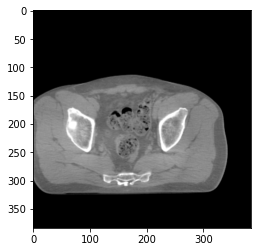

In [28]:
plt.imshow(x.squeeze(), 'gray'),

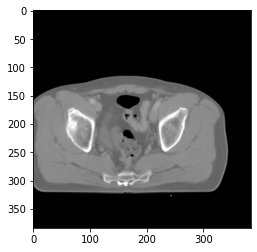

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [37]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:29,  2.80it/s]
84it [01:19,  1.06it/s]
84it [00:26,  3.13it/s]
12it [00:04,  2.91it/s]
84it [00:28,  2.98it/s]
84it [01:19,  1.05it/s]
84it [00:27,  3.11it/s]
12it [00:04,  2.87it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.05it/s]
84it [00:26,  3.12it/s]
12it [00:04,  2.86it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.05it/s]
84it [00:26,  3.11it/s]
12it [00:04,  2.85it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.04it/s]
84it [00:27,  3.10it/s]
12it [00:04,  2.86it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.05it/s]
84it [00:26,  3.12it/s]
12it [00:04,  2.79it/s]
84it [00:28,  2.99it/s]
84it [01:20,  1.04it/s]
84it [00:26,  3.11it/s]
12it [00:04,  2.88it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.05it/s]
84it [00:27,  3.11it/s]
12it [00:04,  2.84it/s]
84it [00:28,  2.97it/s]
84it [01:20,  1.04it/s]
84it [00:27,  3.10it/s]
12it [00:04,  2.85it/s]
84it [00:28,  2.98it/s]
84it [01:20,  1.05it/s]
84it [00:27,  3.10it/s]
12it [00:04,  2.87it/s]
84it [00:28,  2.97it/s]
84it [01:20,  1.

In [38]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [39]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [40]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8576816320419312
psnr score = 23.378829956054688
snr score = 13.441768646240234
mae error = 0.029641052708029747
air dice score = 0.9979825416039306
bone dice score = 0.9232864275998898
contour dice score = 0.4432497024536133


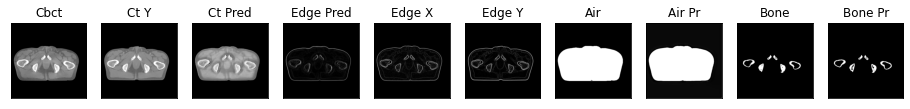

1it [00:00,  2.08it/s]

ssim score = 0.8541664481163025
psnr score = 23.32257843017578
snr score = 13.433050155639648
mae error = 0.029676934704184532
air dice score = 0.9973242567926522
bone dice score = 0.9192208968757478
contour dice score = 0.45601436495780945


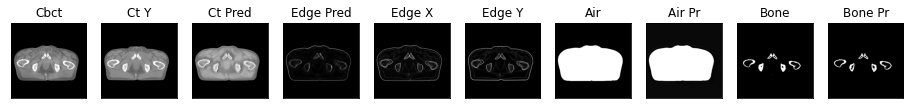

2it [00:00,  2.23it/s]

ssim score = 0.8539989590644836
psnr score = 23.48169708251953
snr score = 13.755067825317383
mae error = 0.029056718572974205
air dice score = 0.9971457254778477
bone dice score = 0.9108606557388466
contour dice score = 0.4769322872161865


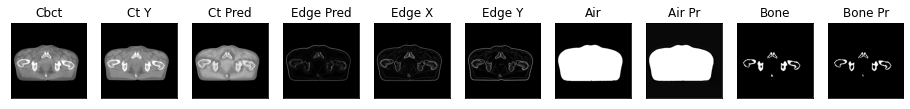

3it [00:01,  2.36it/s]

ssim score = 0.8511067032814026
psnr score = 23.547164916992188
snr score = 13.90978717803955
mae error = 0.02911217324435711
air dice score = 0.9977120315581877
bone dice score = 0.8851534030811665
contour dice score = 0.5594237446784973


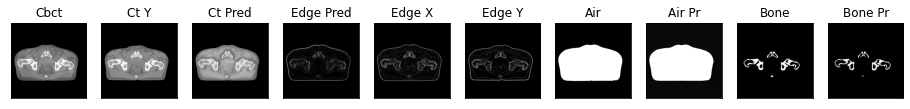

4it [00:01,  2.45it/s]

ssim score = 0.8509710431098938
psnr score = 23.5135498046875
snr score = 13.916474342346191
mae error = 0.029223406687378883
air dice score = 0.997932760309
bone dice score = 0.8571428571444125
contour dice score = 0.5712567567825317


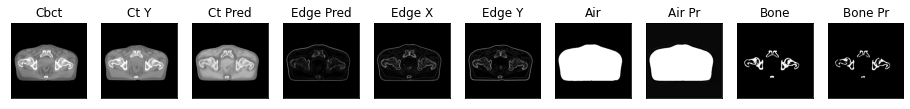

5it [00:01,  2.52it/s]

ssim score = 0.8498541712760925
psnr score = 23.528820037841797
snr score = 14.068279266357422
mae error = 0.029006779193878174
air dice score = 0.9982123348892659
bone dice score = 0.8017467248927536
contour dice score = 0.6103739738464355


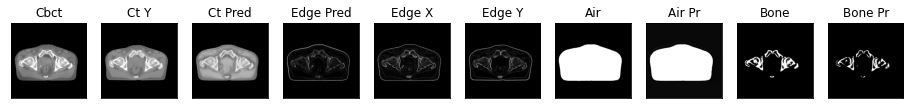

6it [00:02,  2.57it/s]

ssim score = 0.849240243434906
psnr score = 23.420166015625
snr score = 13.93557071685791
mae error = 0.02931848168373108
air dice score = 0.9981510538992793
bone dice score = 0.7766028389084824
contour dice score = 0.5759225487709045


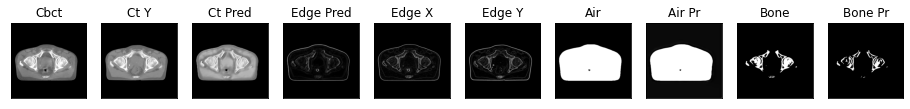

7it [00:02,  2.60it/s]

ssim score = 0.8517435193061829
psnr score = 23.665773391723633
snr score = 13.995637893676758
mae error = 0.028563447296619415
air dice score = 0.9983522887111699
bone dice score = 0.8259907463304568
contour dice score = 0.5245901346206665


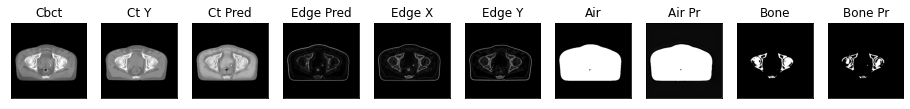

8it [00:03,  2.63it/s]

ssim score = 0.8563188910484314
psnr score = 23.915998458862305
snr score = 14.151309967041016
mae error = 0.02763930894434452
air dice score = 0.9985745625120065
bone dice score = 0.8694827767842676
contour dice score = 0.4844796061515808


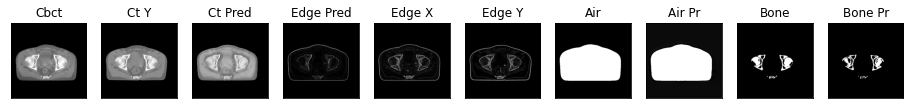

9it [00:03,  2.65it/s]

ssim score = 0.8588559031486511
psnr score = 23.94176483154297
snr score = 14.161791801452637
mae error = 0.027401214465498924
air dice score = 0.9983009634656294
bone dice score = 0.8766943594241725
contour dice score = 0.4679291248321533


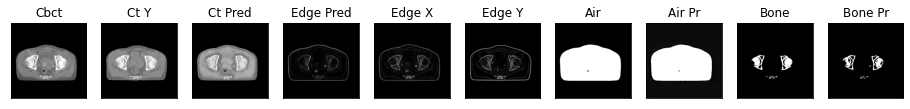

10it [00:04,  2.27it/s]

ssim score = 0.8689795136451721
psnr score = 24.376306533813477
snr score = 14.628604888916016
mae error = 0.025722777470946312
air dice score = 0.9980956671308071
bone dice score = 0.9198739590375885
contour dice score = 0.4354740083217621


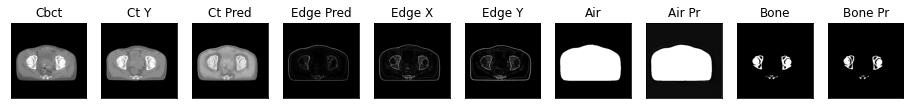

11it [00:04,  2.38it/s]

ssim score = 0.8654610514640808
psnr score = 23.537220001220703
snr score = 13.813227653503418
mae error = 0.02780158258974552
air dice score = 0.9978368643848541
bone dice score = 0.8937889632891504
contour dice score = 0.44675642251968384


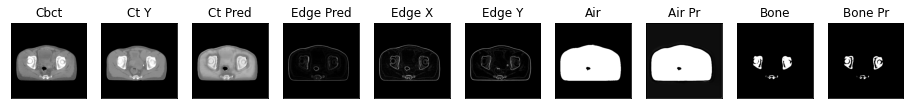

12it [00:04,  2.46it/s]

ssim score = 0.8687055706977844
psnr score = 23.08995819091797
snr score = 13.334040641784668
mae error = 0.028719021007418633
air dice score = 0.997603624909746
bone dice score = 0.9342089552246661
contour dice score = 0.4353157579898834


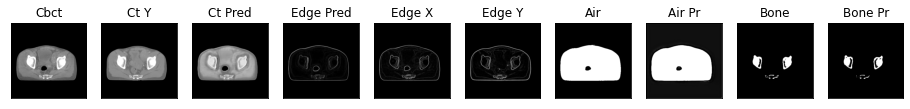

13it [00:05,  2.53it/s]

ssim score = 0.8635161519050598
psnr score = 22.84012794494629
snr score = 12.942255973815918
mae error = 0.029093915596604347
air dice score = 0.9975522262080634
bone dice score = 0.8875453446206161
contour dice score = 0.5348981022834778


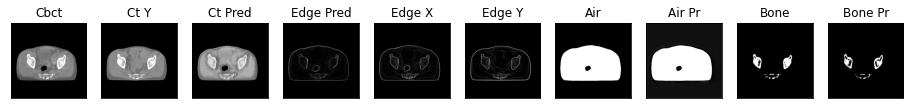

14it [00:05,  2.58it/s]

ssim score = 0.8598771691322327
psnr score = 22.698509216308594
snr score = 12.714975357055664
mae error = 0.029490603134036064
air dice score = 0.9971164447459958
bone dice score = 0.878693181819905
contour dice score = 0.5795314311981201


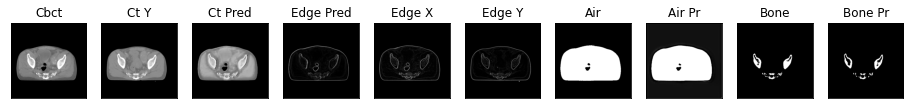

15it [00:05,  2.62it/s]

ssim score = 0.8550283312797546
psnr score = 22.418153762817383
snr score = 12.458105087280273
mae error = 0.030195895582437515
air dice score = 0.9965772048239057
bone dice score = 0.8958389261758948
contour dice score = 0.664160430431366


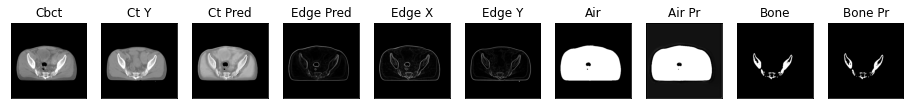

16it [00:06,  2.62it/s]

ssim score = 0.8526064157485962
psnr score = 21.795377731323242
snr score = 11.832784652709961
mae error = 0.03207782655954361
air dice score = 0.9953462317404281
bone dice score = 0.8755520914539419
contour dice score = 0.6704402565956116


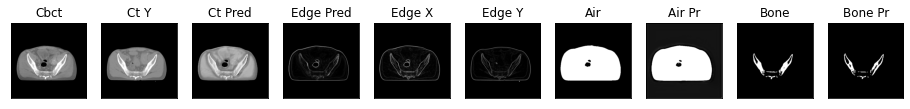

17it [00:06,  2.64it/s]

ssim score = 0.8449966907501221
psnr score = 21.167346954345703
snr score = 11.102995872497559
mae error = 0.03417316824197769
air dice score = 0.9942121067061293
bone dice score = 0.8405015504942631
contour dice score = 0.6112833023071289


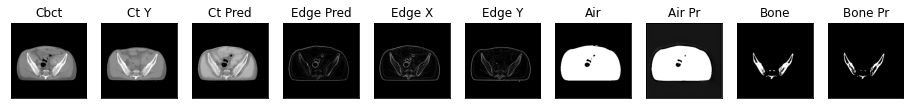

18it [00:07,  2.66it/s]

ssim score = 0.841022789478302
psnr score = 20.759307861328125
snr score = 10.64427375793457
mae error = 0.035482022911310196
air dice score = 0.9919593921956964
bone dice score = 0.8343116328730749
contour dice score = 0.5255101919174194


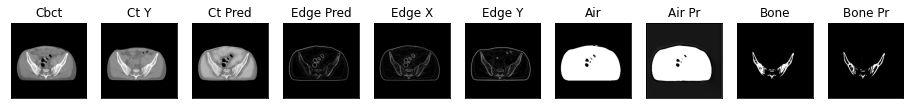

19it [00:07,  2.67it/s]

ssim score = 0.8451295495033264
psnr score = 20.776844024658203
snr score = 10.649499893188477
mae error = 0.034971363842487335
air dice score = 0.9921859523233121
bone dice score = 0.8597826086975573
contour dice score = 0.5783132314682007


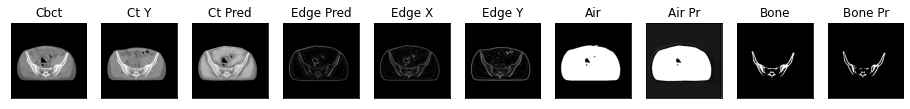

20it [00:07,  2.30it/s]

ssim score = 0.8430705666542053
psnr score = 20.655296325683594
snr score = 10.463102340698242
mae error = 0.034908246248960495
air dice score = 0.990962619620551
bone dice score = 0.8614616965092242
contour dice score = 0.6175528764724731


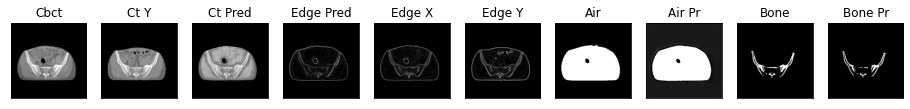

21it [00:08,  2.40it/s]

ssim score = 0.8418337106704712
psnr score = 20.661117553710938
snr score = 10.409496307373047
mae error = 0.0348026342689991
air dice score = 0.9893640742062195
bone dice score = 0.8649971214757485
contour dice score = 0.6029696464538574


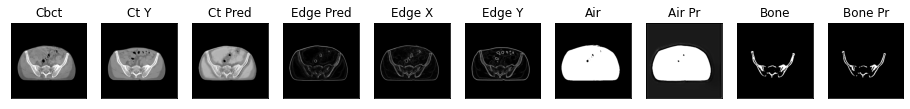

22it [00:08,  2.48it/s]

ssim score = 0.8446341156959534
psnr score = 20.598337173461914
snr score = 10.3132905960083
mae error = 0.03511718660593033
air dice score = 0.9893159021751501
bone dice score = 0.8678634093687696
contour dice score = 0.5649350881576538


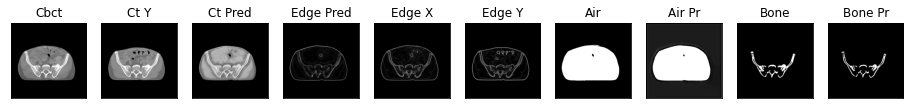

23it [00:09,  2.54it/s]

ssim score = 0.8442439436912537
psnr score = 20.534421920776367
snr score = 10.200807571411133
mae error = 0.03535887226462364
air dice score = 0.9892083874052442
bone dice score = 0.8554943613971218
contour dice score = 0.5638650059700012


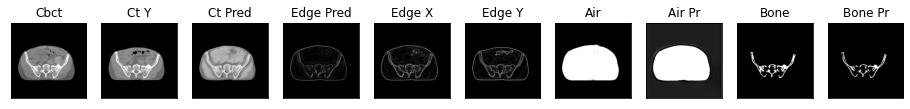

24it [00:09,  2.59it/s]

ssim score = 0.8429641723632812
psnr score = 20.29877471923828
snr score = 9.868162155151367
mae error = 0.03554721921682358
air dice score = 0.988860800406334
bone dice score = 0.8435148578007459
contour dice score = 0.5821596384048462


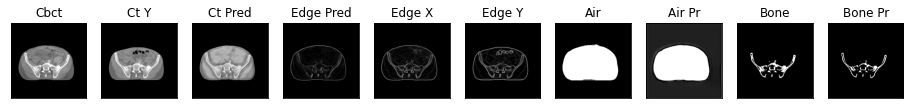

25it [00:09,  2.63it/s]

ssim score = 0.8447811603546143
psnr score = 20.30855369567871
snr score = 9.795206069946289
mae error = 0.03606177866458893
air dice score = 0.9884512951047768
bone dice score = 0.8313605701943316
contour dice score = 0.55027174949646


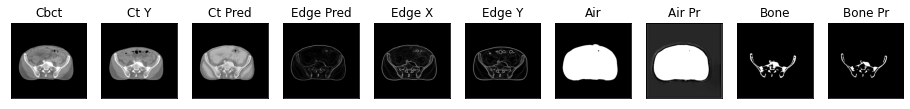

26it [00:10,  2.65it/s]

ssim score = 0.8472662568092346
psnr score = 20.36055564880371
snr score = 9.756019592285156
mae error = 0.03605230525135994
air dice score = 0.9763773908079071
bone dice score = 0.8186750788666414
contour dice score = 0.5616724491119385


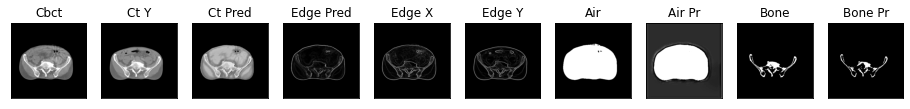

27it [00:10,  2.66it/s]

ssim score = 0.8455963730812073
psnr score = 20.226680755615234
snr score = 9.58104133605957
mae error = 0.03580905497074127
air dice score = 0.9761063334499559
bone dice score = 0.8276687410264759
contour dice score = 0.5450704097747803


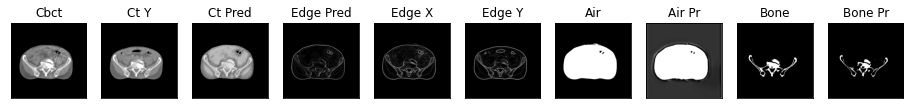

28it [00:10,  2.67it/s]

ssim score = 0.8464524745941162
psnr score = 23.254833221435547
snr score = 14.626988410949707
mae error = 0.02893216349184513
air dice score = 0.9958354507257001
bone dice score = 0.9293526455829337
contour dice score = 0.31350892782211304


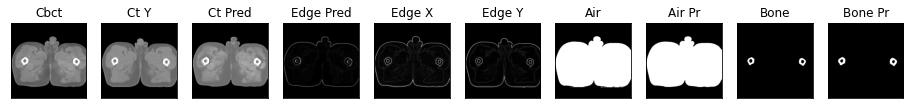

29it [00:11,  2.32it/s]

ssim score = 0.8537831902503967
psnr score = 23.88084602355957
snr score = 15.292261123657227
mae error = 0.027476897463202477
air dice score = 0.9952379199037794
bone dice score = 0.9342214821000772
contour dice score = 0.3030814826488495


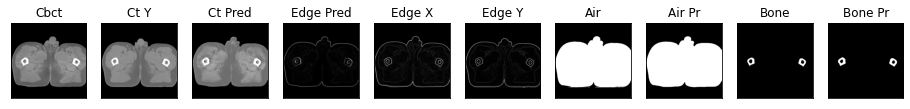

30it [00:11,  2.42it/s]

ssim score = 0.8577051758766174
psnr score = 24.39052391052246
snr score = 15.889387130737305
mae error = 0.026170505210757256
air dice score = 0.9951301570661512
bone dice score = 0.9376514650817878
contour dice score = 0.31028369069099426


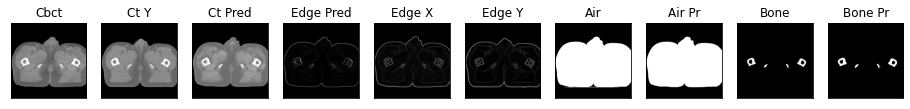

31it [00:12,  2.49it/s]

ssim score = 0.8610526323318481
psnr score = 24.749408721923828
snr score = 16.410829544067383
mae error = 0.02561749331653118
air dice score = 0.9970647865161757
bone dice score = 0.9544895448961487
contour dice score = 0.3448275923728943


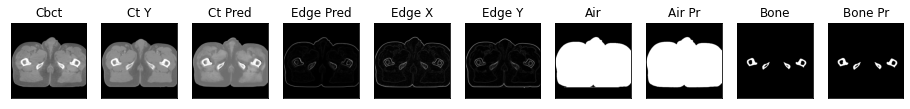

32it [00:12,  2.54it/s]

ssim score = 0.8588853478431702
psnr score = 24.848773956298828
snr score = 16.638338088989258
mae error = 0.025648435577750206
air dice score = 0.9977061044113854
bone dice score = 0.9383597883606037
contour dice score = 0.36515292525291443


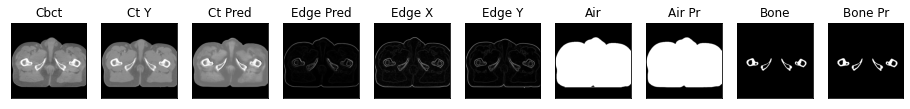

33it [00:12,  2.58it/s]

ssim score = 0.8606598377227783
psnr score = 25.236167907714844
snr score = 17.128971099853516
mae error = 0.025192242115736008
air dice score = 0.9979973617939812
bone dice score = 0.9380717804370386
contour dice score = 0.5174175500869751


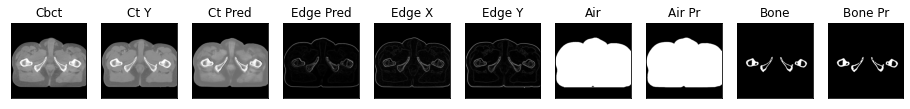

34it [00:13,  2.62it/s]

ssim score = 0.8611391186714172
psnr score = 25.504884719848633
snr score = 17.464786529541016
mae error = 0.025454454123973846
air dice score = 0.9981725015229165
bone dice score = 0.9405605845791192
contour dice score = 0.5241187214851379


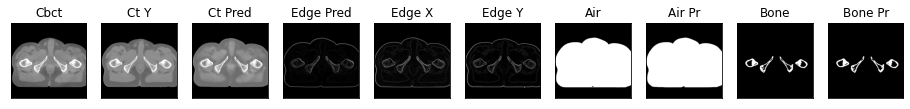

35it [00:13,  2.64it/s]

ssim score = 0.8597140908241272
psnr score = 25.492786407470703
snr score = 17.442800521850586
mae error = 0.025812234729528427
air dice score = 0.9982732956236986
bone dice score = 0.9536960132895173
contour dice score = 0.5576655864715576


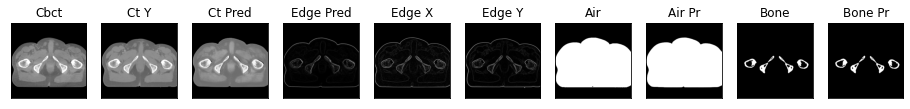

36it [00:14,  2.65it/s]

ssim score = 0.86175537109375
psnr score = 25.78403663635254
snr score = 17.72038459777832
mae error = 0.024904876947402954
air dice score = 0.9983957219251346
bone dice score = 0.9586555314985189
contour dice score = 0.5270958542823792


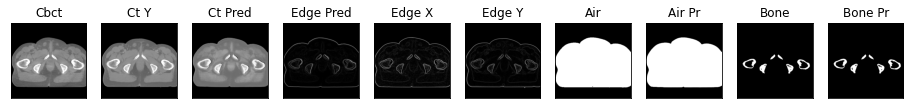

37it [00:14,  2.66it/s]

ssim score = 0.8643694519996643
psnr score = 25.998380661010742
snr score = 17.94672966003418
mae error = 0.024998383596539497
air dice score = 0.99864715725017
bone dice score = 0.9492966961078476
contour dice score = 0.5678554773330688


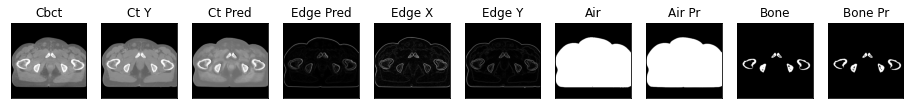

38it [00:14,  2.63it/s]

ssim score = 0.8621886968612671
psnr score = 25.91720962524414
snr score = 17.904645919799805
mae error = 0.02535106986761093
air dice score = 0.9984521500880682
bone dice score = 0.9493345263399023
contour dice score = 0.5742205381393433


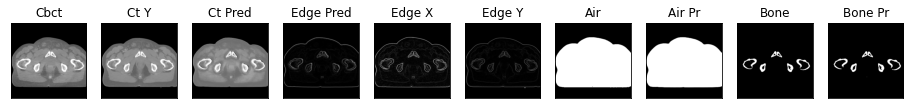

39it [00:15,  2.28it/s]

ssim score = 0.8606444001197815
psnr score = 25.712265014648438
snr score = 17.840988159179688
mae error = 0.02610822767019272
air dice score = 0.9986006024525044
bone dice score = 0.9440342013219585
contour dice score = 0.591798722743988


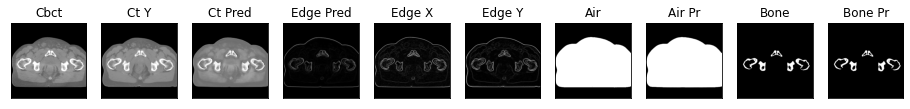

40it [00:15,  2.39it/s]

ssim score = 0.8597815036773682
psnr score = 25.811614990234375
snr score = 18.0350284576416
mae error = 0.026409951969981194
air dice score = 0.9987883827285153
bone dice score = 0.9309373964894755
contour dice score = 0.5737014412879944


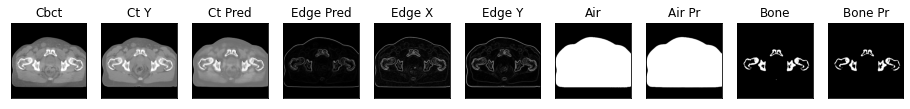

41it [00:16,  2.47it/s]

ssim score = 0.8463503122329712
psnr score = 24.890777587890625
snr score = 17.080142974853516
mae error = 0.02820134535431862
air dice score = 0.9984682778555899
bone dice score = 0.8992107859265109
contour dice score = 0.5978413820266724


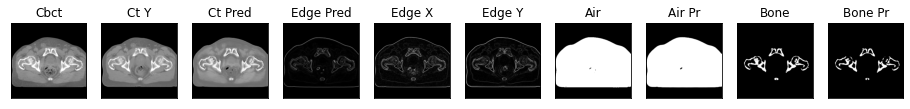

42it [00:16,  2.52it/s]

ssim score = 0.8461923599243164
psnr score = 24.295595169067383
snr score = 16.557144165039062
mae error = 0.028368042781949043
air dice score = 0.9976785896382333
bone dice score = 0.8435948729358851
contour dice score = 0.5463966131210327


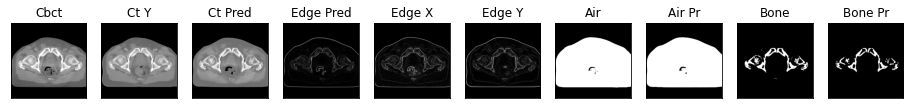

43it [00:16,  2.56it/s]

ssim score = 0.8453865647315979
psnr score = 24.38654327392578
snr score = 16.512001037597656
mae error = 0.027773762121796608
air dice score = 0.99800154098045
bone dice score = 0.8863000090320031
contour dice score = 0.5905660390853882


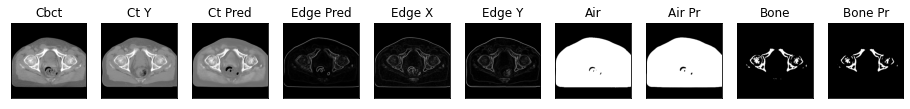

44it [00:17,  2.60it/s]

ssim score = 0.8487163186073303
psnr score = 24.55933380126953
snr score = 16.5062255859375
mae error = 0.02694290317595005
air dice score = 0.9982678809605727
bone dice score = 0.9024908283461818
contour dice score = 0.6142925024032593


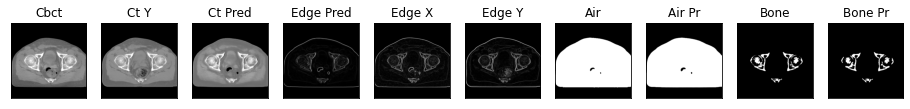

45it [00:17,  2.63it/s]

ssim score = 0.8463934659957886
psnr score = 24.735862731933594
snr score = 16.5921688079834
mae error = 0.027031579986214638
air dice score = 0.9982960930985738
bone dice score = 0.8888181625303542
contour dice score = 0.6009523868560791


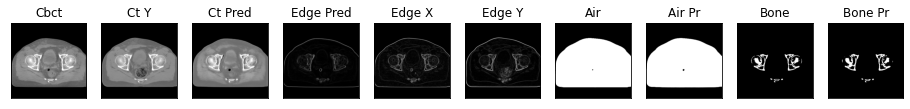

46it [00:18,  2.65it/s]

ssim score = 0.8500540852546692
psnr score = 24.762182235717773
snr score = 16.634178161621094
mae error = 0.026406949386000633
air dice score = 0.9985373994841459
bone dice score = 0.9174997475520802
contour dice score = 0.600666344165802


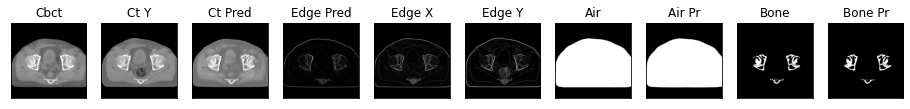

47it [00:18,  2.65it/s]

ssim score = 0.8404637575149536
psnr score = 24.588932037353516
snr score = 16.470964431762695
mae error = 0.027255453169345856
air dice score = 0.9978051189503604
bone dice score = 0.9189586974526819
contour dice score = 0.5992366671562195


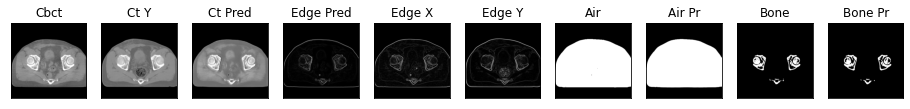

48it [00:18,  2.30it/s]

ssim score = 0.8473776578903198
psnr score = 24.846446990966797
snr score = 16.79006576538086
mae error = 0.026439644396305084
air dice score = 0.9981267217630866
bone dice score = 0.9313680331650727
contour dice score = 0.5655698776245117


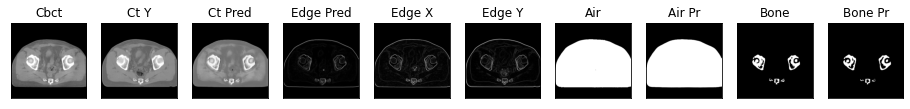

49it [00:19,  2.40it/s]

ssim score = 0.8551611304283142
psnr score = 25.27222442626953
snr score = 17.285926818847656
mae error = 0.026143839582800865
air dice score = 0.9980119284294247
bone dice score = 0.9486789073000567
contour dice score = 0.5507384538650513


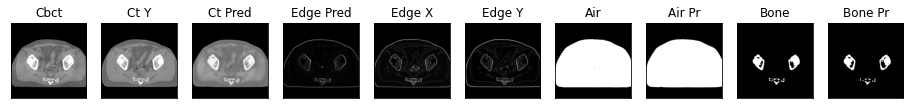

50it [00:19,  2.48it/s]

ssim score = 0.8566350340843201
psnr score = 25.131710052490234
snr score = 17.02630615234375
mae error = 0.026420077309012413
air dice score = 0.9979560896865403
bone dice score = 0.9378519909106032
contour dice score = 0.5319351553916931


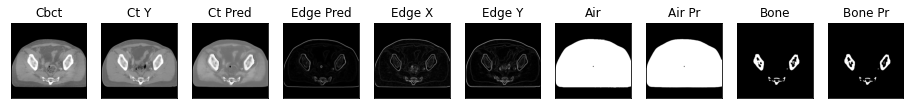

51it [00:20,  2.54it/s]

ssim score = 0.8487794995307922
psnr score = 24.18771743774414
snr score = 16.1639404296875
mae error = 0.029556062072515488
air dice score = 0.9975287747505794
bone dice score = 0.9315955213441953
contour dice score = 0.5193687081336975


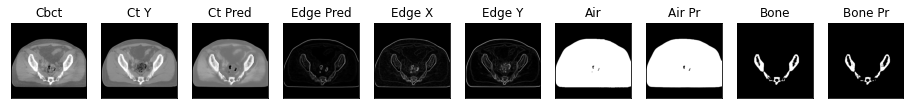

52it [00:20,  2.58it/s]

ssim score = 0.8473121523857117
psnr score = 24.353252410888672
snr score = 16.409624099731445
mae error = 0.029547730460762978
air dice score = 0.9968779842797345
bone dice score = 0.8960742544134505
contour dice score = 0.4702495336532593


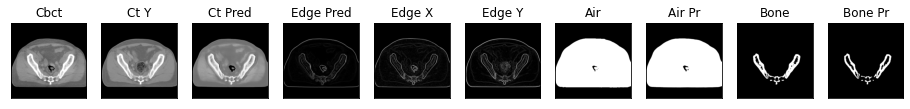

53it [00:20,  2.61it/s]

ssim score = 0.8308781385421753
psnr score = 23.834247589111328
snr score = 15.912174224853516
mae error = 0.030986959114670753
air dice score = 0.9971606001209052
bone dice score = 0.8845473425130025
contour dice score = 0.46746987104415894


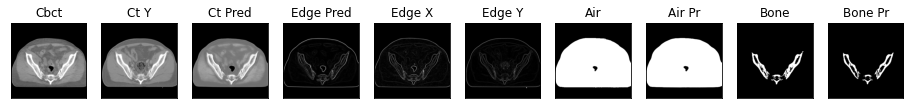

54it [00:21,  2.63it/s]

ssim score = 0.8314223289489746
psnr score = 24.110759735107422
snr score = 16.201229095458984
mae error = 0.030977541580796242
air dice score = 0.9969007639132716
bone dice score = 0.901230769231529
contour dice score = 0.4442307651042938


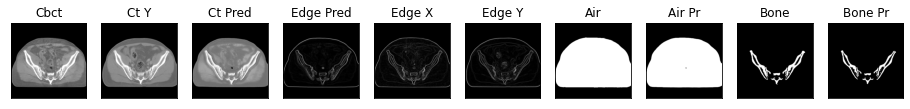

55it [00:21,  2.65it/s]

ssim score = 0.7857611775398254
psnr score = 19.86023712158203
snr score = 9.740446090698242
mae error = 0.044493723660707474
air dice score = 0.9969881940782739
bone dice score = 0.9402907580493175
contour dice score = 0.41814160346984863


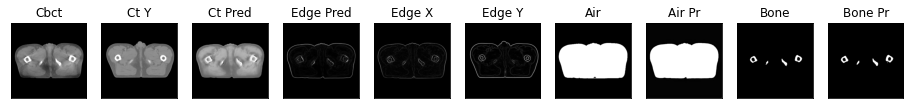

56it [00:21,  2.67it/s]

ssim score = 0.7778686881065369
psnr score = 19.725034713745117
snr score = 9.818222999572754
mae error = 0.044561900198459625
air dice score = 0.9973723457140852
bone dice score = 0.9207066557123931
contour dice score = 0.420936644077301


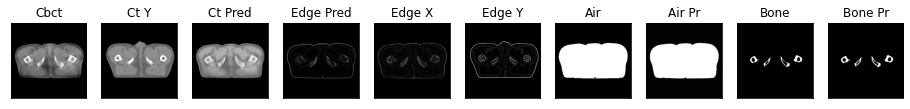

57it [00:22,  2.68it/s]

ssim score = 0.7734357714653015
psnr score = 19.760032653808594
snr score = 9.984358787536621
mae error = 0.044350434094667435
air dice score = 0.9974748366590169
bone dice score = 0.8989938080514901
contour dice score = 0.41318681836128235


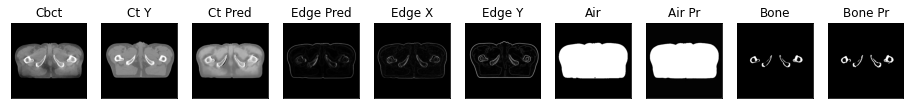

58it [00:22,  2.31it/s]

ssim score = 0.7788730263710022
psnr score = 20.043649673461914
snr score = 10.338377952575684
mae error = 0.04285197705030441
air dice score = 0.9965723928213631
bone dice score = 0.8995125609317677
contour dice score = 0.34520548582077026


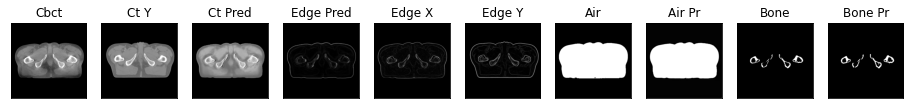

59it [00:23,  2.41it/s]

ssim score = 0.7830789685249329
psnr score = 20.148637771606445
snr score = 10.490933418273926
mae error = 0.04232044890522957
air dice score = 0.9966352388629941
bone dice score = 0.9021638616626195
contour dice score = 0.36333879828453064


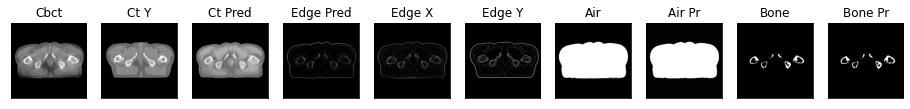

60it [00:23,  2.50it/s]

ssim score = 0.7812233567237854
psnr score = 20.235244750976562
snr score = 10.583158493041992
mae error = 0.041613321751356125
air dice score = 0.9956142649962472
bone dice score = 0.9103299856544058
contour dice score = 0.36199575662612915


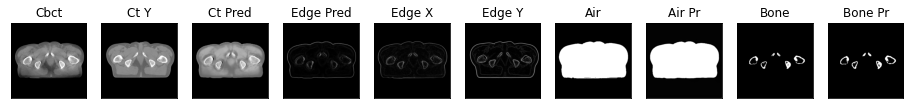

61it [00:24,  2.55it/s]

ssim score = 0.7824758887290955
psnr score = 20.216798782348633
snr score = 10.558208465576172
mae error = 0.041575636714696884
air dice score = 0.9952710646636227
bone dice score = 0.9165755919869476
contour dice score = 0.38125666975975037


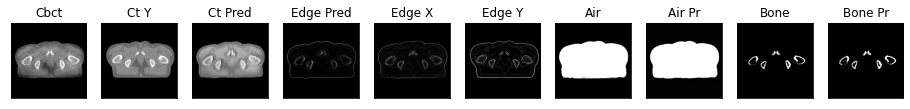

62it [00:24,  2.60it/s]

ssim score = 0.7790879011154175
psnr score = 20.134031295776367
snr score = 10.489551544189453
mae error = 0.041450269520282745
air dice score = 0.9959903490652862
bone dice score = 0.9238705087171136
contour dice score = 0.39319872856140137


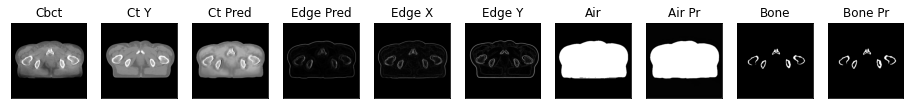

63it [00:24,  2.63it/s]

ssim score = 0.7748777270317078
psnr score = 20.156482696533203
snr score = 10.570009231567383
mae error = 0.04121115431189537
air dice score = 0.9962653911807808
bone dice score = 0.906864324848423
contour dice score = 0.40513095259666443


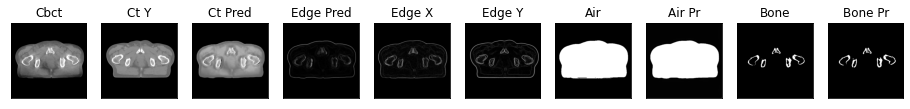

64it [00:25,  2.64it/s]

ssim score = 0.7656670808792114
psnr score = 19.970876693725586
snr score = 10.48296070098877
mae error = 0.042585890740156174
air dice score = 0.9957129768881089
bone dice score = 0.8877706617888416
contour dice score = 0.3511369526386261


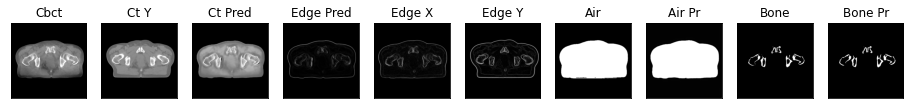

65it [00:25,  2.66it/s]

ssim score = 0.7554640173912048
psnr score = 19.823196411132812
snr score = 10.371110916137695
mae error = 0.04389209672808647
air dice score = 0.995860284605437
bone dice score = 0.8930355568631644
contour dice score = 0.35414424538612366


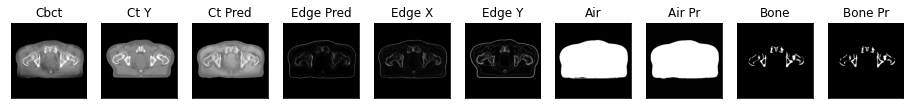

66it [00:25,  2.67it/s]

ssim score = 0.7450627088546753
psnr score = 19.764469146728516
snr score = 10.345090866088867
mae error = 0.04396058991551399
air dice score = 0.9964168819982804
bone dice score = 0.8619710693543062
contour dice score = 0.35691317915916443


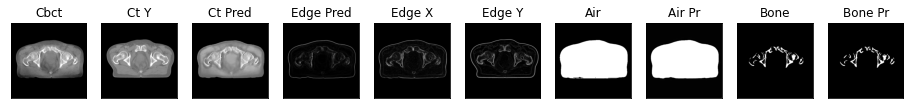

67it [00:26,  2.32it/s]

ssim score = 0.7488570809364319
psnr score = 19.857465744018555
snr score = 10.554905891418457
mae error = 0.04362468421459198
air dice score = 0.9963998415241276
bone dice score = 0.8760159979373499
contour dice score = 0.3328050673007965


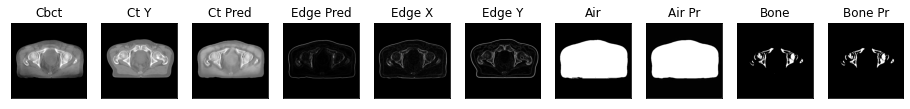

68it [00:26,  2.41it/s]

ssim score = 0.7516903877258301
psnr score = 19.904666900634766
snr score = 10.586118698120117
mae error = 0.04307413846254349
air dice score = 0.9968306462725671
bone dice score = 0.8734636871526053
contour dice score = 0.3104575276374817


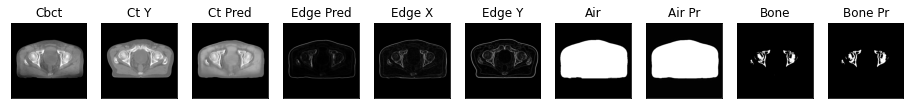

69it [00:27,  2.49it/s]

ssim score = 0.7678346633911133
psnr score = 20.16871452331543
snr score = 10.651002883911133
mae error = 0.041905779391527176
air dice score = 0.9970057819383286
bone dice score = 0.8952717631478087
contour dice score = 0.34067705273628235


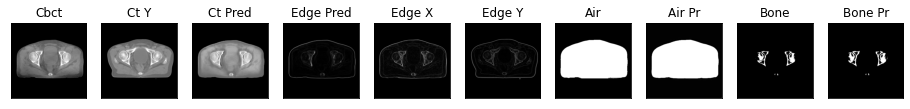

70it [00:27,  2.55it/s]

ssim score = 0.7843536138534546
psnr score = 20.583568572998047
snr score = 10.895462036132812
mae error = 0.0404876209795475
air dice score = 0.9968036294272338
bone dice score = 0.9260539046312916
contour dice score = 0.3530678153038025


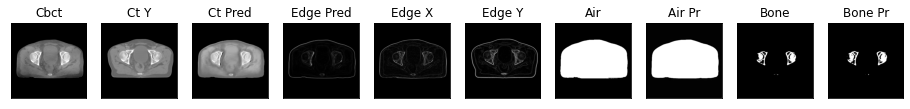

71it [00:27,  2.60it/s]

ssim score = 0.7940356731414795
psnr score = 20.90786361694336
snr score = 11.233928680419922
mae error = 0.03920115903019905
air dice score = 0.996741889018454
bone dice score = 0.9305481639179012
contour dice score = 0.3553895354270935


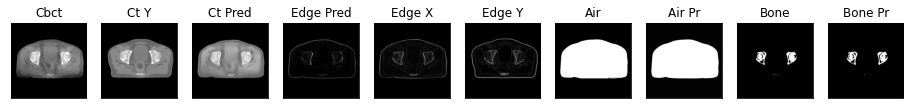

72it [00:28,  2.63it/s]

ssim score = 0.7998657822608948
psnr score = 21.16585922241211
snr score = 11.573749542236328
mae error = 0.038112323731184006
air dice score = 0.9970838001248603
bone dice score = 0.9430894308950801
contour dice score = 0.39435088634490967


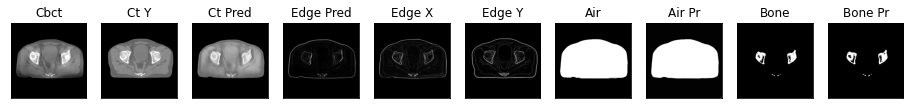

73it [00:28,  2.65it/s]

ssim score = 0.8000422716140747
psnr score = 21.06029510498047
snr score = 11.560361862182617
mae error = 0.038837190717458725
air dice score = 0.9971508027229479
bone dice score = 0.9213011542509174
contour dice score = 0.39669421315193176


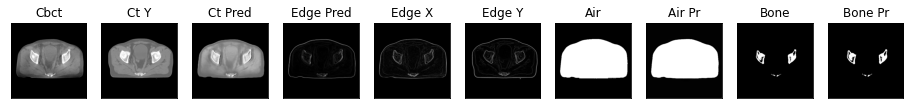

74it [00:29,  2.66it/s]

ssim score = 0.7921647429466248
psnr score = 21.246646881103516
snr score = 11.683284759521484
mae error = 0.03797038272023201
air dice score = 0.9969998045198438
bone dice score = 0.939315687541328
contour dice score = 0.39291465282440186


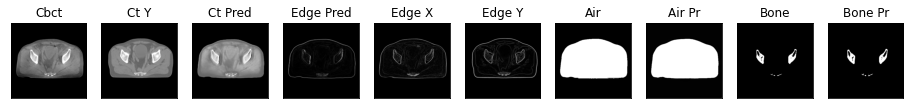

75it [00:29,  2.68it/s]

ssim score = 0.7944737672805786
psnr score = 21.33832550048828
snr score = 11.738569259643555
mae error = 0.03739103674888611
air dice score = 0.9966021066938527
bone dice score = 0.9415710503099458
contour dice score = 0.38805970549583435


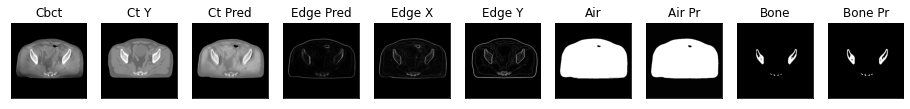

76it [00:29,  2.69it/s]

ssim score = 0.7918734550476074
psnr score = 21.12520408630371
snr score = 11.56319522857666
mae error = 0.038650915026664734
air dice score = 0.9965674279499758
bone dice score = 0.9132510288080123
contour dice score = 0.4089219272136688


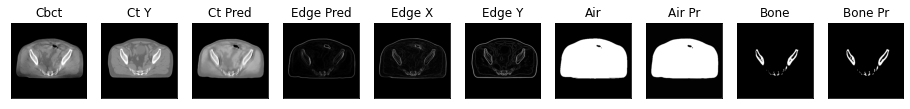

77it [00:30,  2.32it/s]

ssim score = 0.7921721935272217
psnr score = 21.195470809936523
snr score = 11.763964653015137
mae error = 0.03843339905142784
air dice score = 0.9967186915570091
bone dice score = 0.9198890996655495
contour dice score = 0.448128342628479


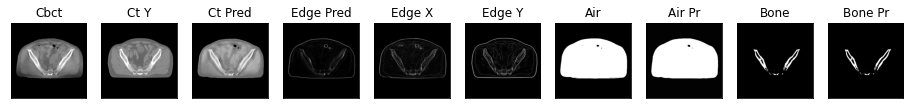

78it [00:30,  2.42it/s]

ssim score = 0.7921881675720215
psnr score = 21.076257705688477
snr score = 11.662500381469727
mae error = 0.039035696536302567
air dice score = 0.9965095539227011
bone dice score = 0.8999374609146351
contour dice score = 0.4242749810218811


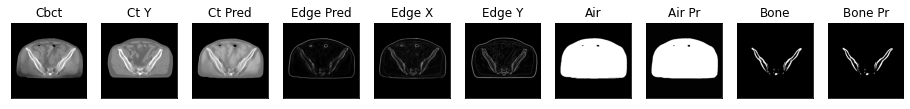

79it [00:31,  2.49it/s]

ssim score = 0.7937777638435364
psnr score = 21.500885009765625
snr score = 12.075860977172852
mae error = 0.03704722225666046
air dice score = 0.9968203906377244
bone dice score = 0.905315614619513
contour dice score = 0.4406047463417053


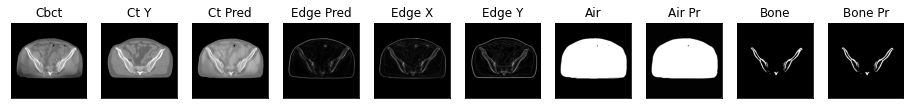

80it [00:31,  2.55it/s]

ssim score = 0.7933663725852966
psnr score = 21.46460723876953
snr score = 12.038843154907227
mae error = 0.03752774000167847
air dice score = 0.9968178065226393
bone dice score = 0.8835108099405694
contour dice score = 0.443113774061203


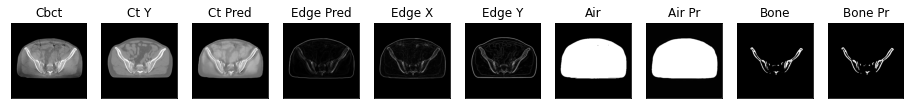

81it [00:31,  2.59it/s]

ssim score = 0.8376352787017822
psnr score = 22.29517936706543
snr score = 12.729314804077148
mae error = 0.033687442541122437
air dice score = 0.9956588355464795
bone dice score = 0.8771691051419813
contour dice score = 0.25212764739990234


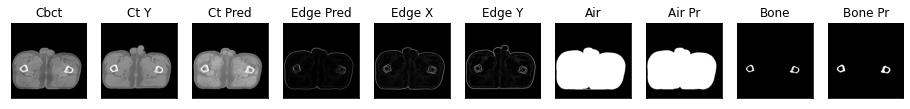

82it [00:32,  2.62it/s]

ssim score = 0.8386754989624023
psnr score = 22.55814552307129
snr score = 13.056671142578125
mae error = 0.03251219540834427
air dice score = 0.995703459428611
bone dice score = 0.8670377241846927
contour dice score = 0.2505263090133667


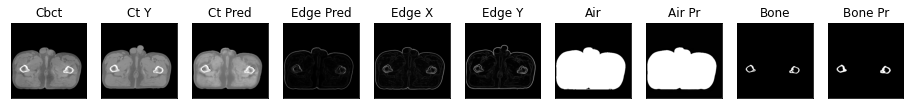

83it [00:32,  2.64it/s]

ssim score = 0.8466049432754517
psnr score = 23.87392807006836
snr score = 14.511667251586914
mae error = 0.02831384912133217
air dice score = 0.9967423649177786
bone dice score = 0.9032125205950738
contour dice score = 0.3265513777732849


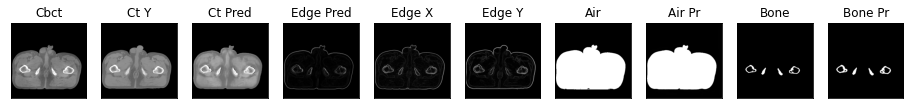

84it [00:32,  2.65it/s]

ssim score = 0.8453207015991211
psnr score = 24.02510643005371
snr score = 14.784337043762207
mae error = 0.027647415176033974
air dice score = 0.997577485414283
bone dice score = 0.8688147295767392
contour dice score = 0.35923829674720764


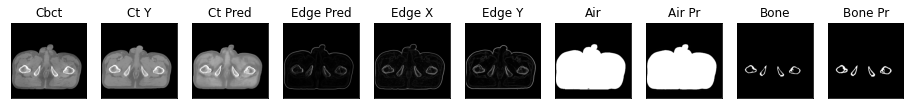

85it [00:33,  2.67it/s]

ssim score = 0.8393526673316956
psnr score = 23.85980987548828
snr score = 14.643213272094727
mae error = 0.028188535943627357
air dice score = 0.9974352198716075
bone dice score = 0.8461686933054204
contour dice score = 0.3761039078235626


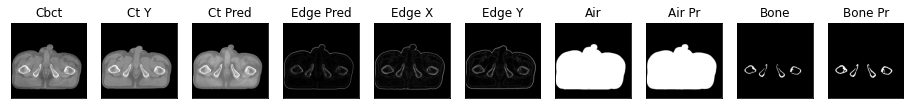

86it [00:33,  2.31it/s]

ssim score = 0.8378745913505554
psnr score = 23.752649307250977
snr score = 14.531655311584473
mae error = 0.028337690979242325
air dice score = 0.9970348521307172
bone dice score = 0.855049151030294
contour dice score = 0.34918975830078125


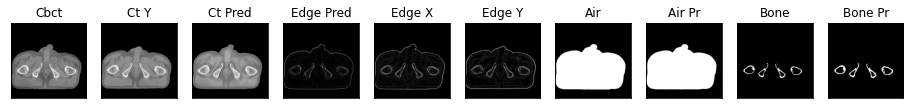

87it [00:34,  2.42it/s]

ssim score = 0.8362889885902405
psnr score = 23.344112396240234
snr score = 14.129373550415039
mae error = 0.029602881520986557
air dice score = 0.9970905197495542
bone dice score = 0.8703835227295742
contour dice score = 0.342977374792099


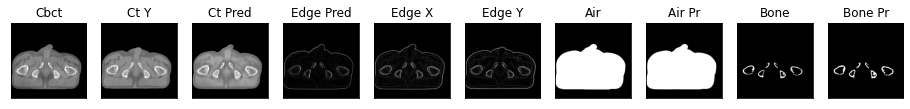

88it [00:34,  2.49it/s]

ssim score = 0.8339232802391052
psnr score = 23.10810089111328
snr score = 13.871805191040039
mae error = 0.030240394175052643
air dice score = 0.9971653787908227
bone dice score = 0.8844707146716018
contour dice score = 0.37130802869796753


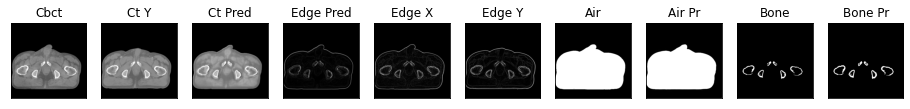

89it [00:34,  2.55it/s]

ssim score = 0.8325852155685425
psnr score = 23.090312957763672
snr score = 13.870929718017578
mae error = 0.03025936521589756
air dice score = 0.9970799623120492
bone dice score = 0.9023047815634279
contour dice score = 0.38155803084373474


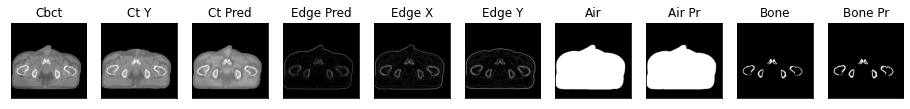

90it [00:35,  2.58it/s]

ssim score = 0.8332237601280212
psnr score = 23.3588809967041
snr score = 14.208089828491211
mae error = 0.029423335567116737
air dice score = 0.9972019445703678
bone dice score = 0.9008613938934869
contour dice score = 0.40341514348983765


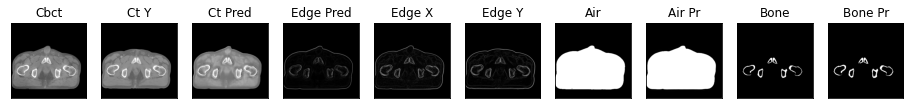

91it [00:35,  2.61it/s]

ssim score = 0.8324666619300842
psnr score = 23.639881134033203
snr score = 14.570449829101562
mae error = 0.02877570129930973
air dice score = 0.9972610910118289
bone dice score = 0.9089586969181361
contour dice score = 0.41912949085235596


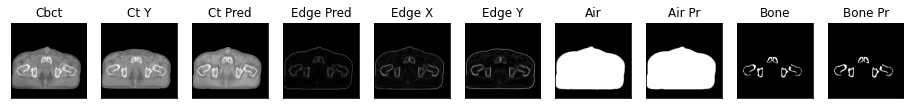

92it [00:36,  2.64it/s]

ssim score = 0.8312339782714844
psnr score = 23.848535537719727
snr score = 14.829805374145508
mae error = 0.028784139081835747
air dice score = 0.9978018168495877
bone dice score = 0.896522832008148
contour dice score = 0.48468565940856934


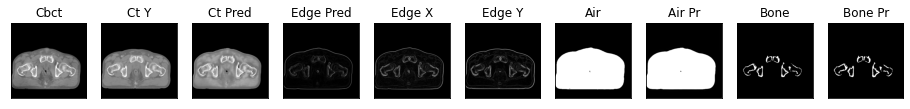

93it [00:36,  2.66it/s]

ssim score = 0.836318850517273
psnr score = 24.324474334716797
snr score = 15.422014236450195
mae error = 0.027372436597943306
air dice score = 0.9979141976771764
bone dice score = 0.8793103448292119
contour dice score = 0.45723506808280945


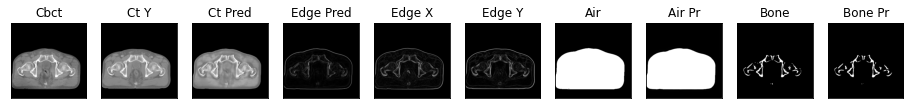

94it [00:36,  2.67it/s]

ssim score = 0.8327695727348328
psnr score = 23.976959228515625
snr score = 15.036260604858398
mae error = 0.027927901595830917
air dice score = 0.9978949375233361
bone dice score = 0.8734124214951373
contour dice score = 0.4787520170211792


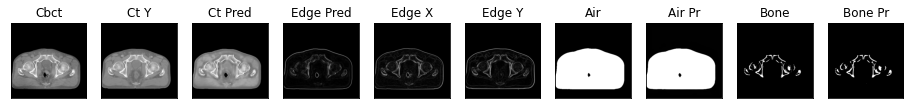

95it [00:37,  2.67it/s]

ssim score = 0.8266816139221191
psnr score = 23.265579223632812
snr score = 14.22921085357666
mae error = 0.029915889725089073
air dice score = 0.9971572482162756
bone dice score = 0.8806145033214345
contour dice score = 0.40690770745277405


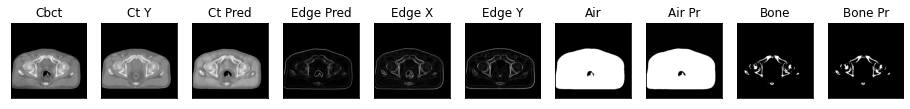

96it [00:37,  2.31it/s]

ssim score = 0.8340739607810974
psnr score = 22.927833557128906
snr score = 13.731706619262695
mae error = 0.030751505866646767
air dice score = 0.9968453749647046
bone dice score = 0.8574001801282287
contour dice score = 0.3937263488769531


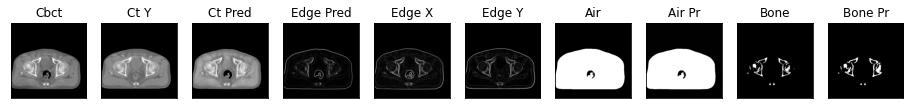

97it [00:38,  2.41it/s]

ssim score = 0.8363437652587891
psnr score = 22.637393951416016
snr score = 13.324843406677246
mae error = 0.03211016207933426
air dice score = 0.9967875022422282
bone dice score = 0.8585109669468873
contour dice score = 0.3845736086368561


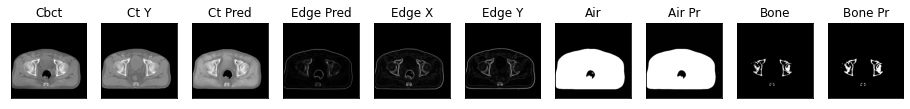

98it [00:38,  2.49it/s]

ssim score = 0.8335567116737366
psnr score = 22.486515045166016
snr score = 13.128870964050293
mae error = 0.03262555971741676
air dice score = 0.9969882237085085
bone dice score = 0.8770037889845963
contour dice score = 0.3986928164958954


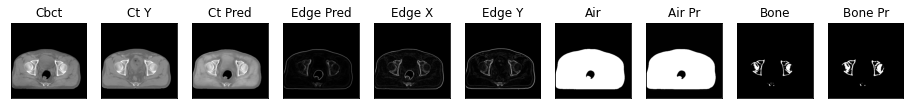

99it [00:38,  2.55it/s]

ssim score = 0.8299193382263184
psnr score = 22.102405548095703
snr score = 12.751434326171875
mae error = 0.03340524062514305
air dice score = 0.9970994009811115
bone dice score = 0.9067108034922252
contour dice score = 0.3409835994243622


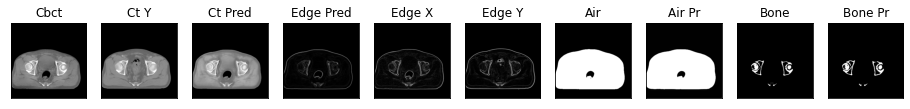

100it [00:39,  2.60it/s]

ssim score = 0.8328975439071655
psnr score = 21.831140518188477
snr score = 12.510272026062012
mae error = 0.03358685225248337
air dice score = 0.9970771548778604
bone dice score = 0.9289810322021911
contour dice score = 0.30727171897888184


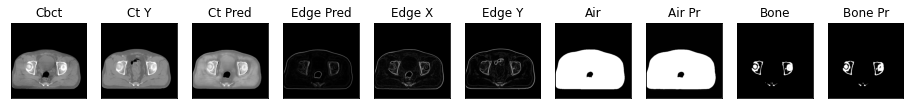

101it [00:39,  2.65it/s]

ssim score = 0.8387643098831177
psnr score = 22.31561851501465
snr score = 12.952164649963379
mae error = 0.031670596450567245
air dice score = 0.9966534283858369
bone dice score = 0.9248947879584835
contour dice score = 0.3004385828971863


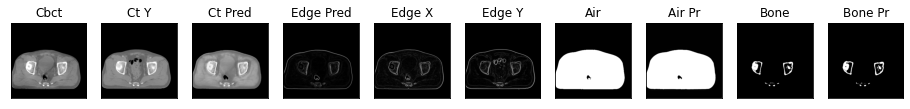

102it [00:39,  2.69it/s]

ssim score = 0.8407390713691711
psnr score = 22.342208862304688
snr score = 12.8885498046875
mae error = 0.03195689246058464
air dice score = 0.996696617336155
bone dice score = 0.9106095610465504
contour dice score = 0.3077765703201294


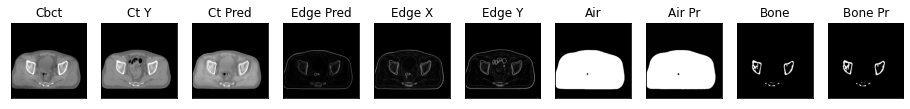

103it [00:40,  2.71it/s]

ssim score = 0.8424432873725891
psnr score = 22.023143768310547
snr score = 12.503761291503906
mae error = 0.033140625804662704
air dice score = 0.9967204359400192
bone dice score = 0.9245318706274913
contour dice score = 0.33241909742355347


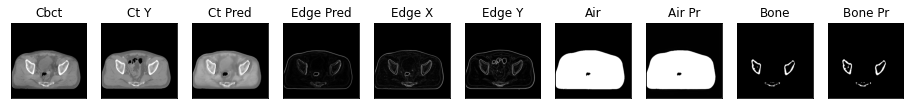

104it [00:40,  2.70it/s]

ssim score = 0.8384144902229309
psnr score = 22.04055404663086
snr score = 12.520865440368652
mae error = 0.033759720623493195
air dice score = 0.9963935942163034
bone dice score = 0.9288731204607388
contour dice score = 0.3491189479827881


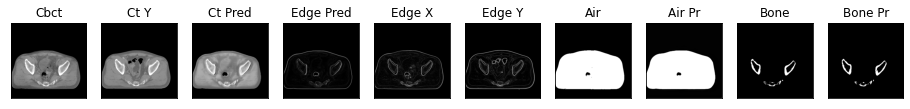

105it [00:41,  2.32it/s]

ssim score = 0.8354042768478394
psnr score = 22.108537673950195
snr score = 12.665018081665039
mae error = 0.03365274891257286
air dice score = 0.9966068914035623
bone dice score = 0.9174964438134069
contour dice score = 0.3637368679046631


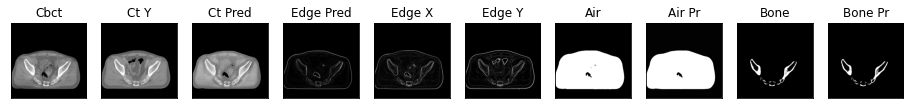

106it [00:41,  2.44it/s]

ssim score = 0.8381590247154236
psnr score = 22.28898048400879
snr score = 12.88104248046875
mae error = 0.033201977610588074
air dice score = 0.9967820408860084
bone dice score = 0.9078052760415039
contour dice score = 0.3867403268814087


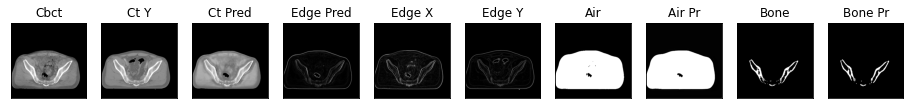

107it [00:42,  2.53it/s]

ssim score = 0.8383240103721619
psnr score = 22.683486938476562
snr score = 13.213851928710938
mae error = 0.03281140327453613
air dice score = 0.9969455693596018
bone dice score = 0.8970232160675542
contour dice score = 0.32945090532302856


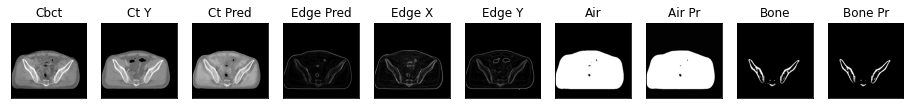

108it [00:42,  2.58it/s]

ssim score = 0.8349806070327759
psnr score = 22.51760482788086
snr score = 12.98670768737793
mae error = 0.03335721045732498
air dice score = 0.9964968125318994
bone dice score = 0.9030837004419517
contour dice score = 0.3122551739215851


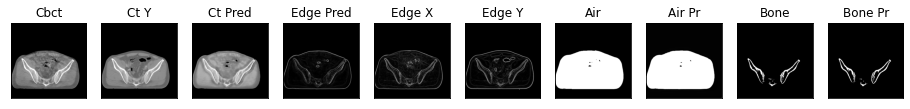

109it [00:42,  2.63it/s]

ssim score = 0.7776257395744324
psnr score = 21.506576538085938
snr score = 13.203882217407227
mae error = 0.03775680437684059
air dice score = 0.9963706233988066
bone dice score = 0.9161589788245965
contour dice score = 0.3807844817638397


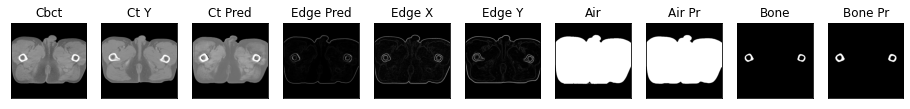

110it [00:43,  2.66it/s]

ssim score = 0.7736095190048218
psnr score = 21.391250610351562
snr score = 13.192849159240723
mae error = 0.03795299306511879
air dice score = 0.9965920615079853
bone dice score = 0.9093733816698764
contour dice score = 0.4047936201095581


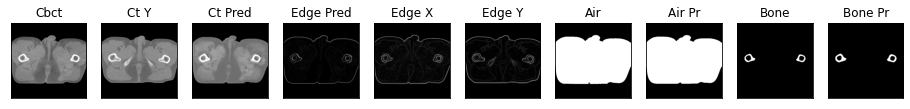

111it [00:43,  2.69it/s]

ssim score = 0.7713044881820679
psnr score = 21.141023635864258
snr score = 13.070577621459961
mae error = 0.03951461985707283
air dice score = 0.9968809656671286
bone dice score = 0.8785685564962089
contour dice score = 0.40071555972099304


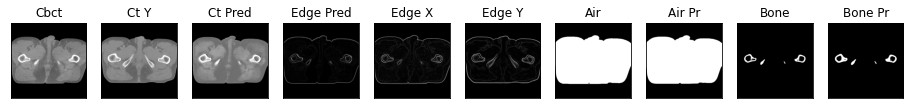

112it [00:43,  2.69it/s]

ssim score = 0.7654193639755249
psnr score = 20.674898147583008
snr score = 12.636739730834961
mae error = 0.040877316147089005
air dice score = 0.9970604080294211
bone dice score = 0.9064282410990222
contour dice score = 0.3899371027946472


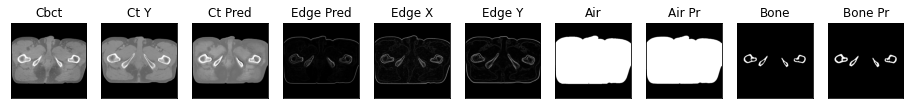

113it [00:44,  2.71it/s]

ssim score = 0.750801682472229
psnr score = 20.391185760498047
snr score = 12.38326644897461
mae error = 0.04302667826414108
air dice score = 0.9970863525688578
bone dice score = 0.8878725287712028
contour dice score = 0.43380028009414673


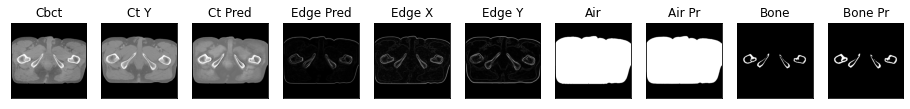

114it [00:44,  2.73it/s]

ssim score = 0.7459387183189392
psnr score = 20.20948600769043
snr score = 12.23598575592041
mae error = 0.04474474489688873
air dice score = 0.9970017872840867
bone dice score = 0.8934356351251288
contour dice score = 0.4457504451274872


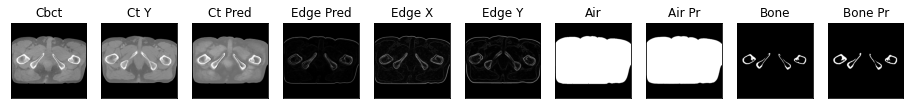

115it [00:45,  2.33it/s]

ssim score = 0.7420313954353333
psnr score = 19.903318405151367
snr score = 11.950125694274902
mae error = 0.046273428946733475
air dice score = 0.9971234036630223
bone dice score = 0.9091373149577701
contour dice score = 0.45266005396842957


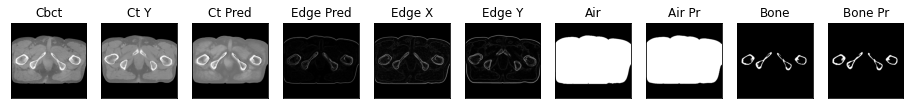

116it [00:45,  2.41it/s]

ssim score = 0.7395387887954712
psnr score = 19.889659881591797
snr score = 11.975543975830078
mae error = 0.04568986967206001
air dice score = 0.9966585785349884
bone dice score = 0.9171567374083718
contour dice score = 0.48833033442497253


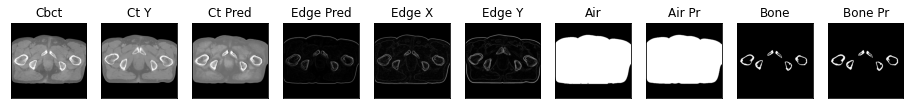

117it [00:45,  2.50it/s]

ssim score = 0.7392053008079529
psnr score = 19.945270538330078
snr score = 12.079830169677734
mae error = 0.04540751129388809
air dice score = 0.9962188109810847
bone dice score = 0.9306610232798374
contour dice score = 0.4862983822822571


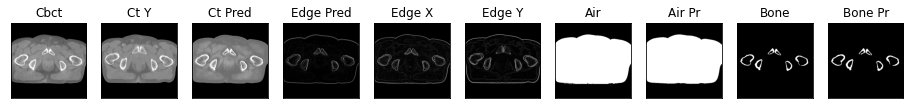

118it [00:46,  2.57it/s]

ssim score = 0.7329695820808411
psnr score = 19.800151824951172
snr score = 11.957324981689453
mae error = 0.04699583724141121
air dice score = 0.9963826622448351
bone dice score = 0.9249940091070572
contour dice score = 0.5


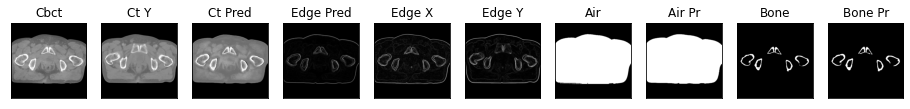

119it [00:46,  2.62it/s]

ssim score = 0.7207878232002258
psnr score = 19.80057716369629
snr score = 12.000527381896973
mae error = 0.04841388389468193
air dice score = 0.9969162181515806
bone dice score = 0.9222410865883164
contour dice score = 0.4921243190765381


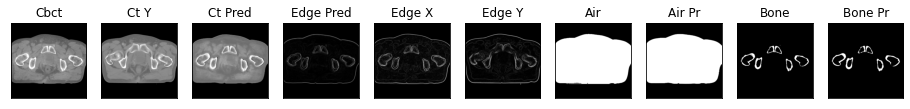

120it [00:47,  2.63it/s]

ssim score = 0.721061110496521
psnr score = 19.839759826660156
snr score = 12.098050117492676
mae error = 0.048324085772037506
air dice score = 0.9970598896451747
bone dice score = 0.9254135025494079
contour dice score = 0.48319709300994873


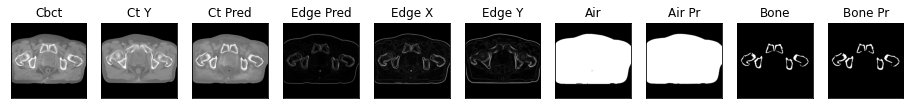

121it [00:47,  2.66it/s]

ssim score = 0.7148967981338501
psnr score = 19.765823364257812
snr score = 11.948740005493164
mae error = 0.04921853914856911
air dice score = 0.997752576489997
bone dice score = 0.9046927914861665
contour dice score = 0.47354015707969666


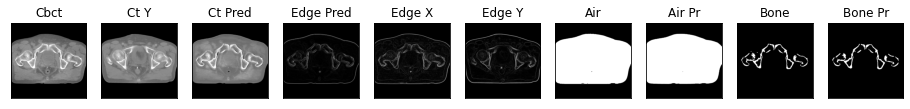

122it [00:47,  2.69it/s]

ssim score = 0.7166028022766113
psnr score = 19.818437576293945
snr score = 11.894134521484375
mae error = 0.04884729161858559
air dice score = 0.9977527056619185
bone dice score = 0.8906460945044297
contour dice score = 0.4407864511013031


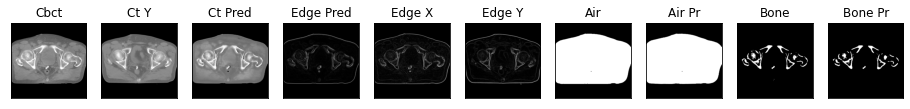

123it [00:48,  2.71it/s]

ssim score = 0.7270943522453308
psnr score = 20.10755157470703
snr score = 12.060161590576172
mae error = 0.04770280420780182
air dice score = 0.9978481260284704
bone dice score = 0.8636319706208212
contour dice score = 0.4460761845111847


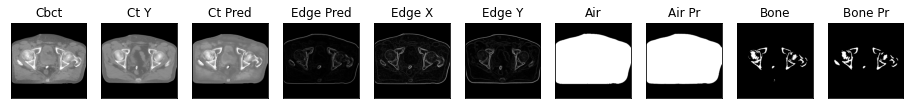

124it [00:48,  2.70it/s]

ssim score = 0.736174464225769
psnr score = 20.240285873413086
snr score = 12.080467224121094
mae error = 0.04687575623393059
air dice score = 0.9981024011258713
bone dice score = 0.8826309570708681
contour dice score = 0.43048498034477234


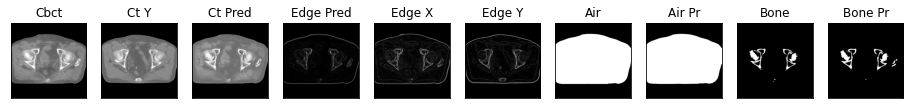

125it [00:49,  2.32it/s]

ssim score = 0.736305832862854
psnr score = 20.478267669677734
snr score = 12.267803192138672
mae error = 0.04451419413089752
air dice score = 0.9978599109260236
bone dice score = 0.9167718753042947
contour dice score = 0.42724746465682983


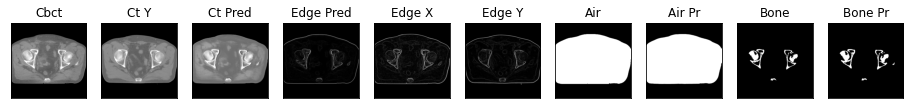

126it [00:49,  2.43it/s]

ssim score = 0.7359551191329956
psnr score = 20.32306480407715
snr score = 12.144752502441406
mae error = 0.04554751515388489
air dice score = 0.9978870377895177
bone dice score = 0.9192367199595747
contour dice score = 0.41860464215278625


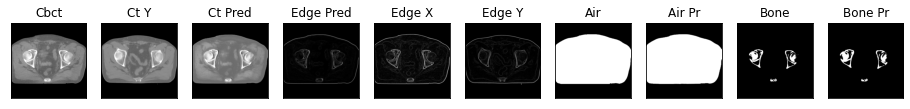

127it [00:49,  2.52it/s]

ssim score = 0.7364652156829834
psnr score = 20.177209854125977
snr score = 12.012375831604004
mae error = 0.04613777995109558
air dice score = 0.9978028126329545
bone dice score = 0.9215340533400757
contour dice score = 0.37248480319976807


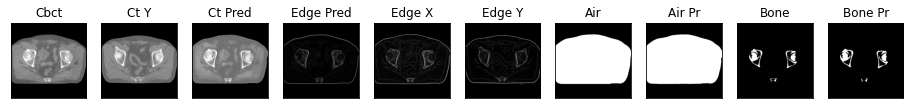

128it [00:50,  2.57it/s]

ssim score = 0.7362548112869263
psnr score = 19.86334228515625
snr score = 11.557016372680664
mae error = 0.04756251350045204
air dice score = 0.997774367744733
bone dice score = 0.9333484728064795
contour dice score = 0.34134840965270996


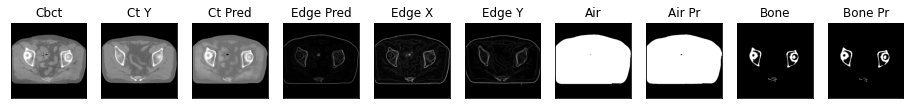

129it [00:50,  2.63it/s]

ssim score = 0.7430445551872253
psnr score = 19.824111938476562
snr score = 11.458478927612305
mae error = 0.04813053831458092
air dice score = 0.9976330942876335
bone dice score = 0.9258444415694856
contour dice score = 0.33049243688583374


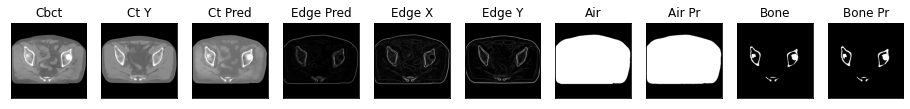

130it [00:50,  2.66it/s]

ssim score = 0.7320424318313599
psnr score = 19.936979293823242
snr score = 11.596994400024414
mae error = 0.04659413546323776
air dice score = 0.9974496286872407
bone dice score = 0.8608221892048733
contour dice score = 0.3342803120613098


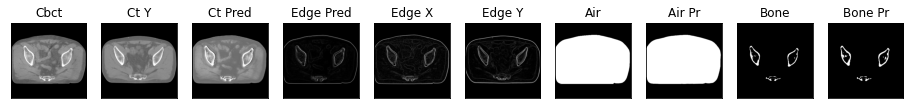

131it [00:51,  2.69it/s]

ssim score = 0.7280386090278625
psnr score = 19.799468994140625
snr score = 11.532296180725098
mae error = 0.047050781548023224
air dice score = 0.9971680489285009
bone dice score = 0.8907401473904079
contour dice score = 0.3284429609775543


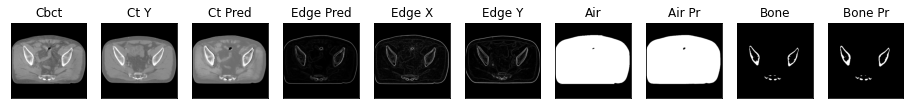

132it [00:51,  2.69it/s]

ssim score = 0.7243683934211731
psnr score = 19.54907989501953
snr score = 11.411136627197266
mae error = 0.048298466950654984
air dice score = 0.9970846179173294
bone dice score = 0.9053047575633788
contour dice score = 0.3519313335418701


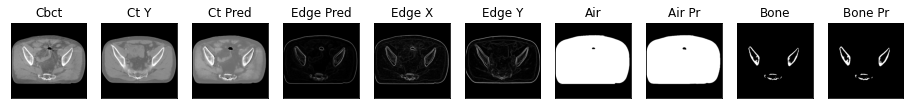

133it [00:51,  2.71it/s]

ssim score = 0.7207557559013367
psnr score = 19.48548698425293
snr score = 11.381505966186523
mae error = 0.04869634658098221
air dice score = 0.9970014089765068
bone dice score = 0.9141485456097974
contour dice score = 0.320230096578598


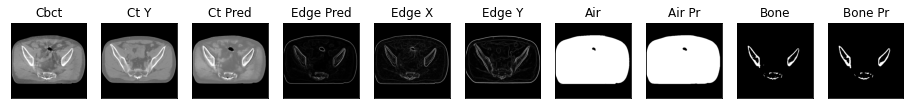

134it [00:52,  2.34it/s]

ssim score = 0.7121015787124634
psnr score = 19.462955474853516
snr score = 11.329183578491211
mae error = 0.04970791935920715
air dice score = 0.9973504258028708
bone dice score = 0.9096278795049069
contour dice score = 0.33092832565307617


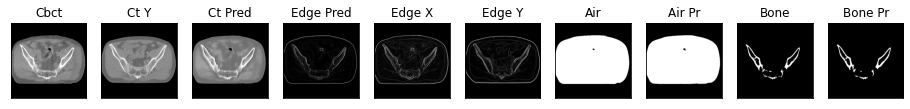

135it [00:52,  2.45it/s]

ssim score = 0.7078425288200378
psnr score = 19.531091690063477
snr score = 11.333943367004395
mae error = 0.04898524284362793
air dice score = 0.9974810778080548
bone dice score = 0.8967927118445427
contour dice score = 0.37584540247917175


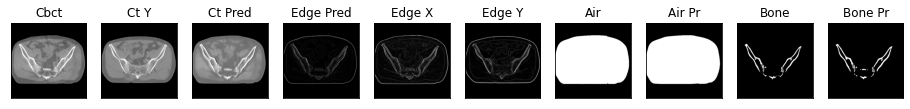

136it [00:53,  2.51it/s]

ssim score = 0.8143681287765503
psnr score = 22.999004364013672
snr score = 14.476395606994629
mae error = 0.028787506744265556
air dice score = 0.9975081208561404
bone dice score = 0.9027265150624749
contour dice score = 0.4444444477558136


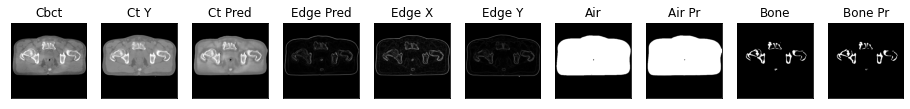

137it [00:53,  2.58it/s]

ssim score = 0.8158298134803772
psnr score = 22.997241973876953
snr score = 14.514644622802734
mae error = 0.028723713010549545
air dice score = 0.9979557095174746
bone dice score = 0.8964668226037613
contour dice score = 0.43469491600990295


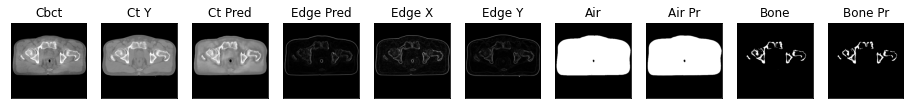

138it [00:53,  2.63it/s]

ssim score = 0.8176335096359253
psnr score = 23.153526306152344
snr score = 14.678716659545898
mae error = 0.028181228786706924
air dice score = 0.997849942342746
bone dice score = 0.8828715365254046
contour dice score = 0.4293670952320099


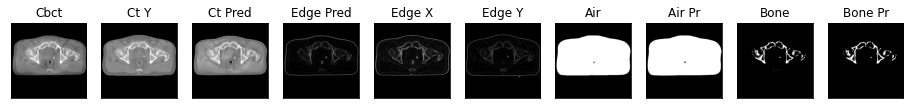

139it [00:54,  2.67it/s]

ssim score = 0.8204004764556885
psnr score = 22.992046356201172
snr score = 14.458816528320312
mae error = 0.02878570184111595
air dice score = 0.9972821623236039
bone dice score = 0.8859217615379956
contour dice score = 0.45099034905433655


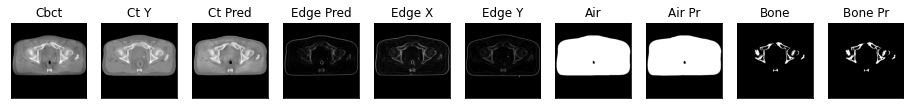

140it [00:54,  2.68it/s]

ssim score = 0.8287615776062012
psnr score = 23.00074005126953
snr score = 14.311885833740234
mae error = 0.027951816096901894
air dice score = 0.9970486007071395
bone dice score = 0.8543170275346924
contour dice score = 0.44954127073287964


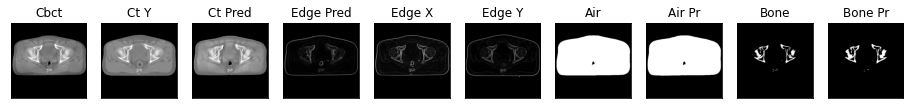

141it [00:55,  2.69it/s]

ssim score = 0.8326651453971863
psnr score = 23.163480758666992
snr score = 14.453824996948242
mae error = 0.027144385501742363
air dice score = 0.9971849594258839
bone dice score = 0.8867222578590542
contour dice score = 0.4396727979183197


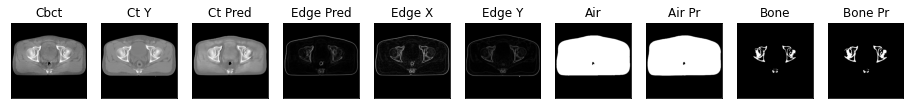

142it [00:55,  2.71it/s]

ssim score = 0.8302404880523682
psnr score = 23.0747127532959
snr score = 14.34942626953125
mae error = 0.027299867942929268
air dice score = 0.9970776971048134
bone dice score = 0.8984204443315985
contour dice score = 0.44227808713912964


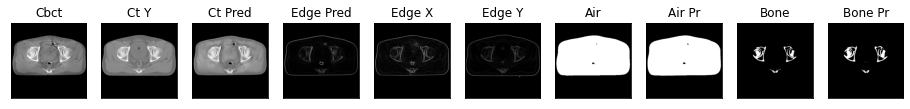

143it [00:55,  2.71it/s]

ssim score = 0.8240377902984619
psnr score = 22.440994262695312
snr score = 13.725071907043457
mae error = 0.029231151565909386
air dice score = 0.9973521757550102
bone dice score = 0.9029251876792269
contour dice score = 0.4451313614845276


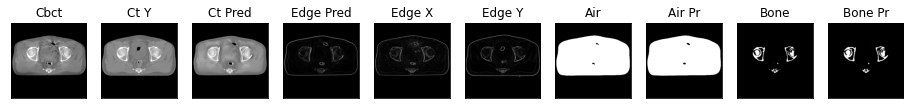

144it [00:56,  2.32it/s]

ssim score = 0.8187964558601379
psnr score = 22.494123458862305
snr score = 13.833979606628418
mae error = 0.02965698018670082
air dice score = 0.997582545829325
bone dice score = 0.9255874673638957
contour dice score = 0.4252457320690155


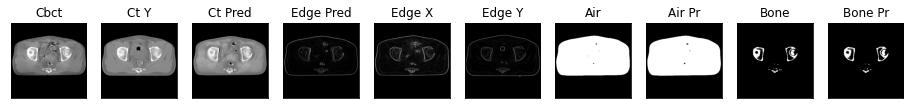

145it [00:56,  2.44it/s]

ssim score = 0.8178383708000183
psnr score = 22.090890884399414
snr score = 13.408821105957031
mae error = 0.031231572851538658
air dice score = 0.9967931872367353
bone dice score = 0.923201950427696
contour dice score = 0.4145454466342926


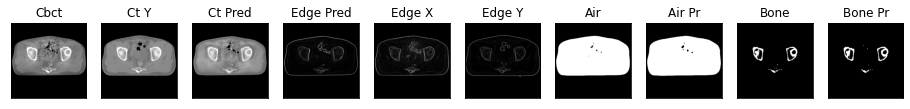

146it [00:57,  2.51it/s]

ssim score = 0.8190560340881348
psnr score = 21.57964515686035
snr score = 12.826800346374512
mae error = 0.03266273811459541
air dice score = 0.996666870527799
bone dice score = 0.906116433310153
contour dice score = 0.4342379868030548


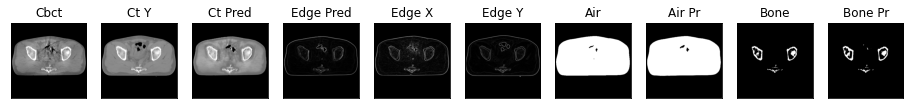

147it [00:57,  2.57it/s]

ssim score = 0.819281816482544
psnr score = 21.80298614501953
snr score = 13.006247520446777
mae error = 0.03193990886211395
air dice score = 0.9968874035439267
bone dice score = 0.8996932515352808
contour dice score = 0.4528301954269409


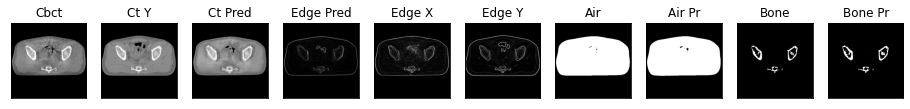

148it [00:57,  2.62it/s]

ssim score = 0.8181328773498535
psnr score = 21.967205047607422
snr score = 13.169370651245117
mae error = 0.03154944255948067
air dice score = 0.9969757909764995
bone dice score = 0.9147334459991591
contour dice score = 0.46105262637138367


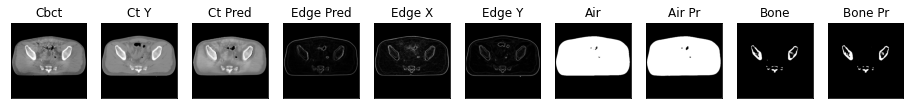

149it [00:58,  2.65it/s]

ssim score = 0.8123521208763123
psnr score = 21.836366653442383
snr score = 13.051887512207031
mae error = 0.032804224640131
air dice score = 0.9962131437077286
bone dice score = 0.9271662411784477
contour dice score = 0.4002106487751007


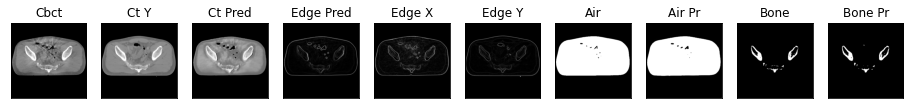

150it [00:58,  2.67it/s]

ssim score = 0.8118643760681152
psnr score = 21.889060974121094
snr score = 13.159786224365234
mae error = 0.03303292766213417
air dice score = 0.9960648829535098
bone dice score = 0.9247256294393192
contour dice score = 0.4463247060775757


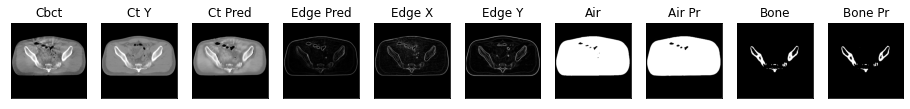

151it [00:58,  2.68it/s]

ssim score = 0.8117547035217285
psnr score = 21.541488647460938
snr score = 12.831583023071289
mae error = 0.033625561743974686
air dice score = 0.9961274300570439
bone dice score = 0.9109835846802218
contour dice score = 0.44833067059516907


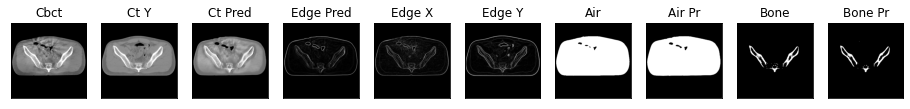

152it [00:59,  2.70it/s]

ssim score = 0.8158524036407471
psnr score = 21.650522232055664
snr score = 12.885876655578613
mae error = 0.033200547099113464
air dice score = 0.9963870927726377
bone dice score = 0.9151333618611449
contour dice score = 0.3832271695137024


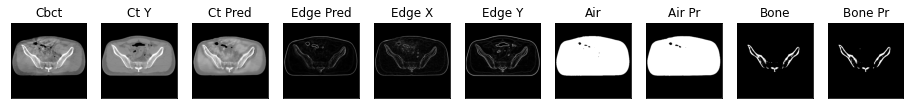

153it [00:59,  2.32it/s]

ssim score = 0.8154770135879517
psnr score = 21.716917037963867
snr score = 12.91592025756836
mae error = 0.03317677229642868
air dice score = 0.9965832758714223
bone dice score = 0.8969969127154505
contour dice score = 0.37526652216911316


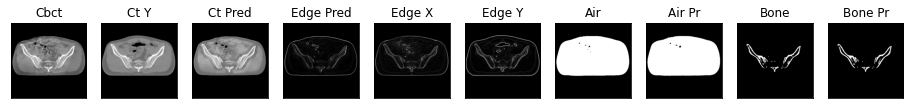

154it [01:00,  2.43it/s]

ssim score = 0.8191264271736145
psnr score = 21.809673309326172
snr score = 13.00875186920166
mae error = 0.03335464373230934
air dice score = 0.9966523046402803
bone dice score = 0.893035143771335
contour dice score = 0.3706480860710144


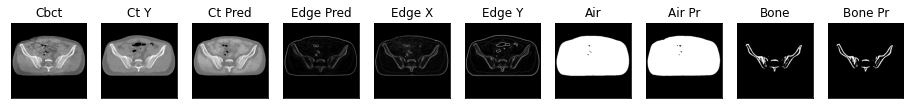

155it [01:00,  2.51it/s]

ssim score = 0.8165302276611328
psnr score = 21.91950798034668
snr score = 13.117161750793457
mae error = 0.033472564071416855
air dice score = 0.9967089943804552
bone dice score = 0.8859389096547758
contour dice score = 0.39892473816871643


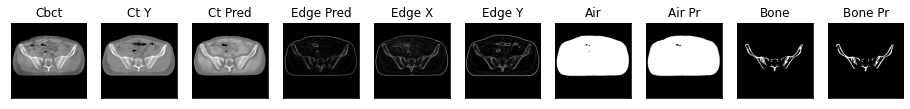

156it [01:01,  2.56it/s]

ssim score = 0.8050415515899658
psnr score = 21.38037872314453
snr score = 12.583072662353516
mae error = 0.03619171306490898
air dice score = 0.9963541179770058
bone dice score = 0.8816783945806401
contour dice score = 0.33586132526397705


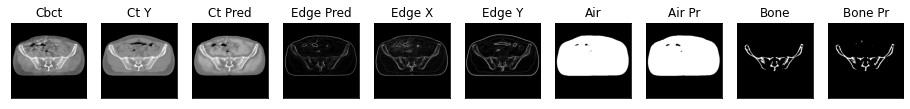

157it [01:01,  2.61it/s]

ssim score = 0.7947999238967896
psnr score = 20.638957977294922
snr score = 11.82437801361084
mae error = 0.03971618413925171
air dice score = 0.9944805958447711
bone dice score = 0.8659684475690578
contour dice score = 0.39694657921791077


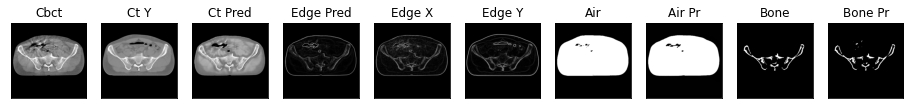

158it [01:01,  2.65it/s]

ssim score = 0.7934153079986572
psnr score = 20.556720733642578
snr score = 11.723518371582031
mae error = 0.04026053473353386
air dice score = 0.9950848937157456
bone dice score = 0.8684807256252396
contour dice score = 0.398901104927063


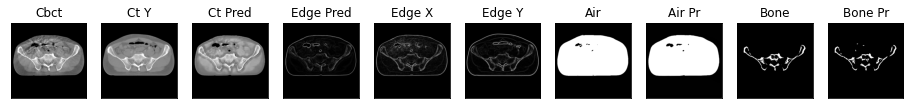

159it [01:02,  2.67it/s]

ssim score = 0.7849763035774231
psnr score = 20.187870025634766
snr score = 11.30872631072998
mae error = 0.042273275554180145
air dice score = 0.9952099494164383
bone dice score = 0.8698203153664611
contour dice score = 0.374172180891037


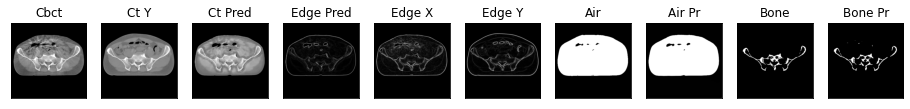

160it [01:02,  2.69it/s]

ssim score = 0.7816117405891418
psnr score = 20.174983978271484
snr score = 11.242046356201172
mae error = 0.04255547747015953
air dice score = 0.9950548405503115
bone dice score = 0.87092130518389
contour dice score = 0.337402880191803


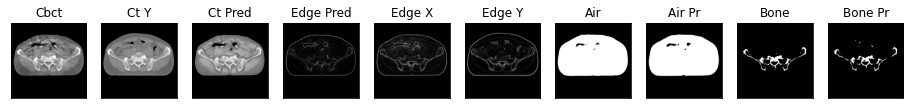

161it [01:02,  2.70it/s]

ssim score = 0.7790981531143188
psnr score = 20.01378631591797
snr score = 11.111308097839355
mae error = 0.04369710385799408
air dice score = 0.9947293832900792
bone dice score = 0.8887054939885792
contour dice score = 0.3351893126964569


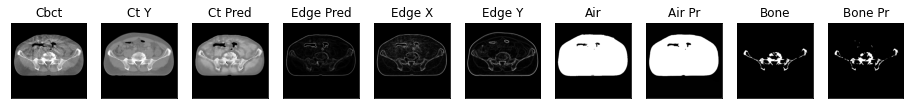

162it [01:03,  2.70it/s]

ssim score = 0.7764901518821716
psnr score = 19.847383499145508
snr score = 10.889680862426758
mae error = 0.04442039504647255
air dice score = 0.9951179820992716
bone dice score = 0.8800393313682394
contour dice score = 0.3062360882759094


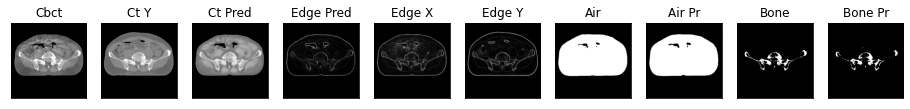

163it [01:03,  2.32it/s]

ssim score = 0.7866635322570801
psnr score = 20.42005157470703
snr score = 11.314817428588867
mae error = 0.041731562465429306
air dice score = 0.9955781172676951
bone dice score = 0.9000126726663286
contour dice score = 0.25167784094810486


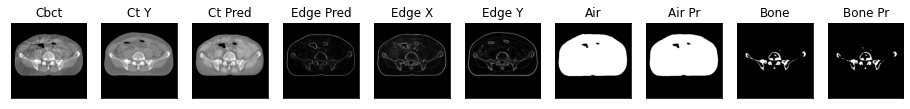

164it [01:04,  2.43it/s]

ssim score = 0.8418322801589966
psnr score = 22.91264533996582
snr score = 13.293556213378906
mae error = 0.03683364763855934
air dice score = 0.9955353842969742
bone dice score = 0.8808945065658509
contour dice score = 0.3474041819572449


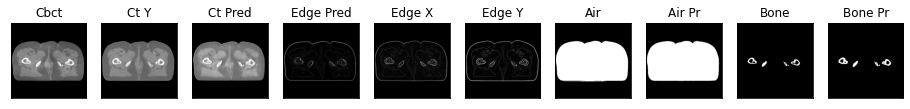

165it [01:04,  2.51it/s]

ssim score = 0.843485414981842
psnr score = 23.202716827392578
snr score = 13.704643249511719
mae error = 0.03556240722537041
air dice score = 0.9956405589478661
bone dice score = 0.8839137645131858
contour dice score = 0.36300691962242126


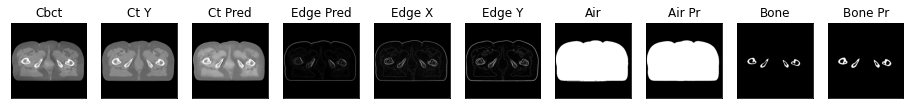

166it [01:04,  2.57it/s]

ssim score = 0.8388804197311401
psnr score = 23.244869232177734
snr score = 13.829710006713867
mae error = 0.03504917025566101
air dice score = 0.9956905666430931
bone dice score = 0.8821221744838011
contour dice score = 0.3408203125


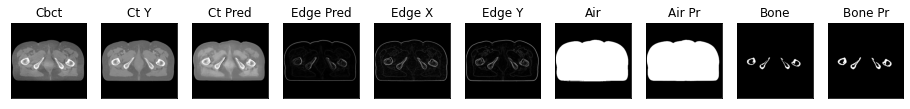

167it [01:05,  2.61it/s]

ssim score = 0.8366556763648987
psnr score = 23.25666046142578
snr score = 13.904945373535156
mae error = 0.03501839563250542
air dice score = 0.9959149319034415
bone dice score = 0.8916470982909821
contour dice score = 0.3603515625


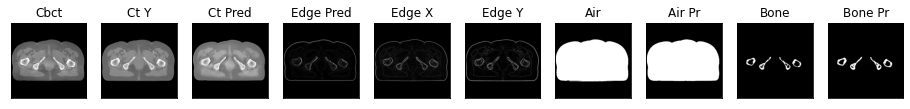

168it [01:05,  2.64it/s]

ssim score = 0.8352962136268616
psnr score = 23.195199966430664
snr score = 13.8719482421875
mae error = 0.03520224615931511
air dice score = 0.9957120647890411
bone dice score = 0.911085639431618
contour dice score = 0.35039371252059937


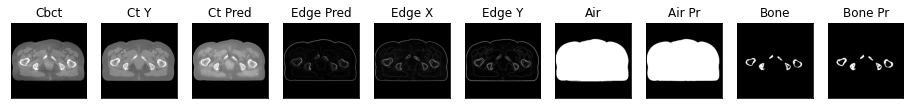

169it [01:05,  2.66it/s]

ssim score = 0.8353126645088196
psnr score = 23.186798095703125
snr score = 13.886500358581543
mae error = 0.03500289469957352
air dice score = 0.9958681559572856
bone dice score = 0.9005768578232003
contour dice score = 0.3630170226097107


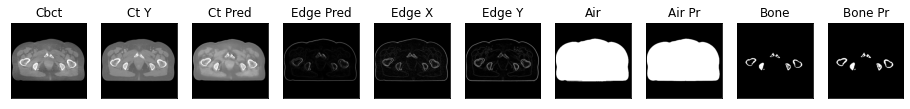

170it [01:06,  2.68it/s]

ssim score = 0.8331488370895386
psnr score = 23.16742706298828
snr score = 13.898454666137695
mae error = 0.03477850928902626
air dice score = 0.9955961084566263
bone dice score = 0.8959170013404297
contour dice score = 0.3617021143436432


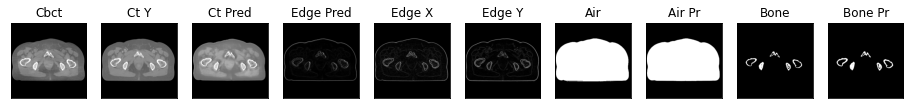

171it [01:06,  2.70it/s]

ssim score = 0.8300145864486694
psnr score = 23.0085391998291
snr score = 13.787935256958008
mae error = 0.035285379737615585
air dice score = 0.9954437002328489
bone dice score = 0.9017492234771661
contour dice score = 0.3676539659500122


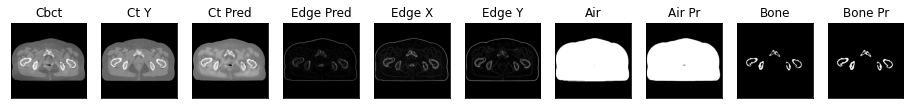

172it [01:07,  2.32it/s]

ssim score = 0.8302963376045227
psnr score = 22.814220428466797
snr score = 13.636358261108398
mae error = 0.035534366965293884
air dice score = 0.995333520280136
bone dice score = 0.8956321839096455
contour dice score = 0.3700144290924072


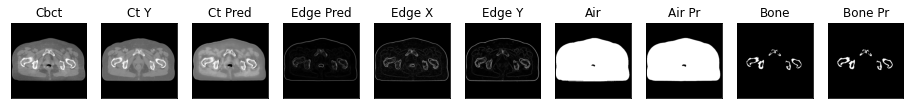

173it [01:07,  2.42it/s]

ssim score = 0.8255242109298706
psnr score = 22.726913452148438
snr score = 13.63675308227539
mae error = 0.0356946736574173
air dice score = 0.9947592037440459
bone dice score = 0.9027926960270839
contour dice score = 0.3814866840839386


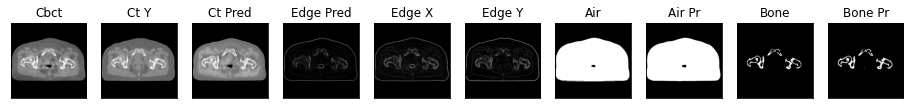

174it [01:08,  2.50it/s]

ssim score = 0.8312047123908997
psnr score = 23.61966896057129
snr score = 14.642781257629395
mae error = 0.032844431698322296
air dice score = 0.9942909470732202
bone dice score = 0.9167542323418942
contour dice score = 0.33425670862197876


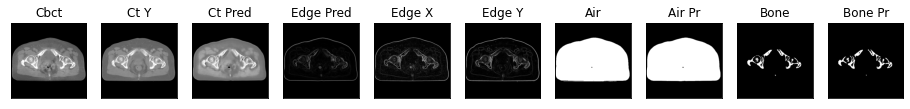

175it [01:08,  2.57it/s]

ssim score = 0.8353833556175232
psnr score = 23.0022029876709
snr score = 13.896761894226074
mae error = 0.034706857055425644
air dice score = 0.9940197048573807
bone dice score = 0.8629595867538292
contour dice score = 0.3561517000198364


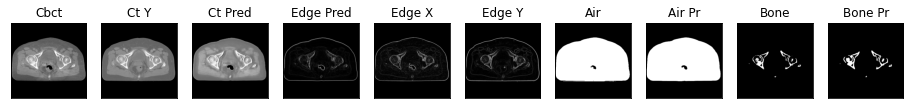

176it [01:08,  2.61it/s]

ssim score = 0.8393735289573669
psnr score = 23.012598037719727
snr score = 13.797737121582031
mae error = 0.03470770642161369
air dice score = 0.9942961147656145
bone dice score = 0.829485488129461
contour dice score = 0.37026646733283997


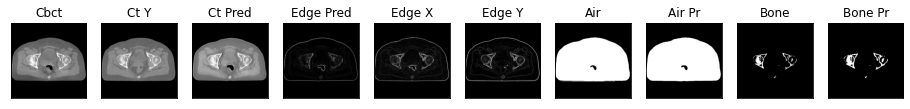

177it [01:09,  2.63it/s]

ssim score = 0.8431543111801147
psnr score = 23.006343841552734
snr score = 13.764354705810547
mae error = 0.03475921228528023
air dice score = 0.994478374227655
bone dice score = 0.8829803679102955
contour dice score = 0.3924805223941803


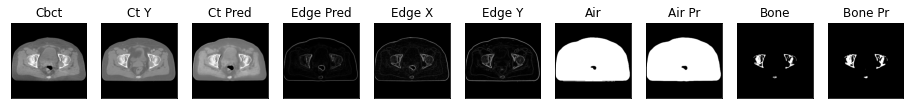

178it [01:09,  2.65it/s]

ssim score = 0.8465286493301392
psnr score = 23.3011417388916
snr score = 14.051149368286133
mae error = 0.03470008447766304
air dice score = 0.9947524591208813
bone dice score = 0.8944815039433827
contour dice score = 0.37552544474601746


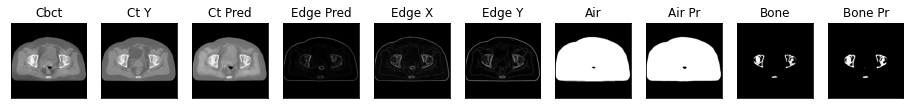

179it [01:09,  2.67it/s]

ssim score = 0.8480273485183716
psnr score = 23.953332901000977
snr score = 14.737568855285645
mae error = 0.032879579812288284
air dice score = 0.9952065802494297
bone dice score = 0.9176575505363012
contour dice score = 0.34213006496429443


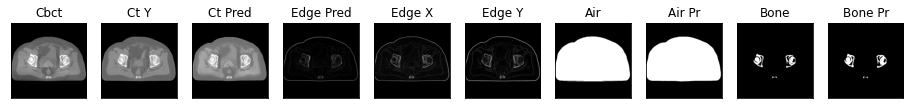

180it [01:10,  2.69it/s]

ssim score = 0.8461160063743591
psnr score = 23.595619201660156
snr score = 14.431346893310547
mae error = 0.03368639945983887
air dice score = 0.9956741921327447
bone dice score = 0.9304650810493794
contour dice score = 0.33445459604263306


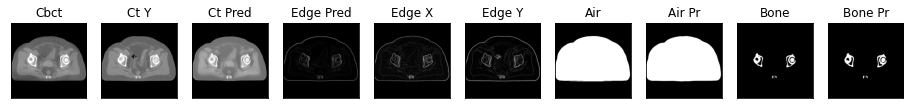

181it [01:10,  2.71it/s]

ssim score = 0.8334670662879944
psnr score = 22.9446964263916
snr score = 13.817981719970703
mae error = 0.03543829172849655
air dice score = 0.9961242720056401
bone dice score = 0.923824959482596
contour dice score = 0.35055530071258545


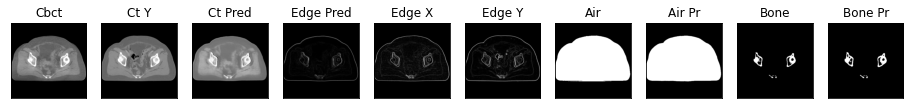

182it [01:11,  2.32it/s]

ssim score = 0.8163371682167053
psnr score = 21.609676361083984
snr score = 12.41052532196045
mae error = 0.04012058302760124
air dice score = 0.995130649475348
bone dice score = 0.8710317460343049
contour dice score = 0.3198044002056122


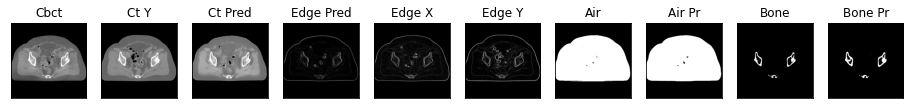

183it [01:11,  2.43it/s]

ssim score = 0.8068603873252869
psnr score = 21.32598114013672
snr score = 12.10883903503418
mae error = 0.042022958397865295
air dice score = 0.995134666693965
bone dice score = 0.8918973530027905
contour dice score = 0.34683793783187866


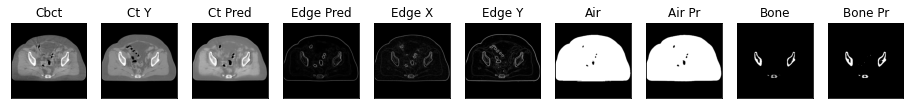

184it [01:11,  2.51it/s]

ssim score = 0.8050574064254761
psnr score = 21.767702102661133
snr score = 12.615472793579102
mae error = 0.04069582372903824
air dice score = 0.995449328202015
bone dice score = 0.8999412571000599
contour dice score = 0.3334977924823761


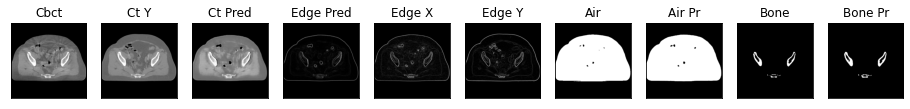

185it [01:12,  2.57it/s]

ssim score = 0.8078862428665161
psnr score = 21.95819091796875
snr score = 12.86105728149414
mae error = 0.04001761972904205
air dice score = 0.9953512638542401
bone dice score = 0.9178294573657566
contour dice score = 0.33150821924209595


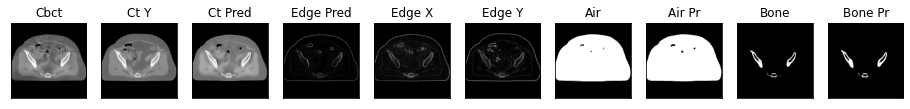

186it [01:12,  2.62it/s]

ssim score = 0.8044902086257935
psnr score = 21.440160751342773
snr score = 12.407456398010254
mae error = 0.04164024069905281
air dice score = 0.9959348516949179
bone dice score = 0.921006436513736
contour dice score = 0.34069710969924927


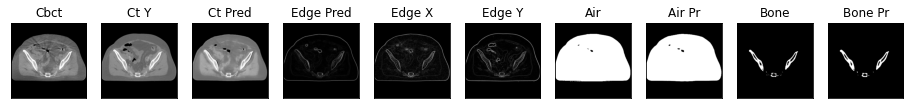

187it [01:13,  2.65it/s]

ssim score = 0.8058021068572998
psnr score = 21.410659790039062
snr score = 12.450815200805664
mae error = 0.0417068712413311
air dice score = 0.9959942211715288
bone dice score = 0.9100853788699295
contour dice score = 0.31527093052864075


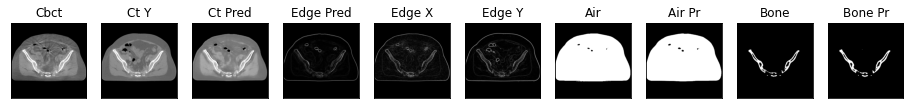

188it [01:13,  2.67it/s]

ssim score = 0.8051592707633972
psnr score = 21.310274124145508
snr score = 12.346138954162598
mae error = 0.0425950363278389
air dice score = 0.9955246340557788
bone dice score = 0.8893344025676378
contour dice score = 0.341796875


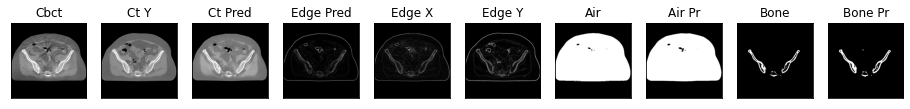

189it [01:13,  2.68it/s]

ssim score = 0.8033340573310852
psnr score = 21.389938354492188
snr score = 12.40362548828125
mae error = 0.042523909360170364
air dice score = 0.9963622760284333
bone dice score = 0.8798174442205905
contour dice score = 0.36001941561698914


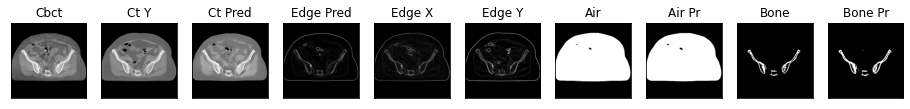

190it [01:14,  2.70it/s]

ssim score = 0.8099100589752197
psnr score = 22.03036880493164
snr score = 13.055688858032227
mae error = 0.040473077446222305
air dice score = 0.9966062263921843
bone dice score = 0.8809744472410833
contour dice score = 0.3461909294128418


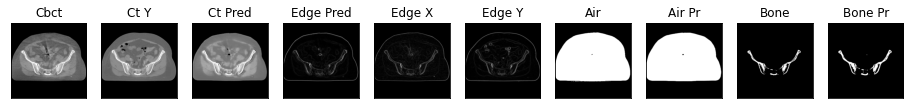

191it [01:14,  2.55it/s]


In [41]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [42]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [43]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [44]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:07, 24.54it/s]


(0.813959817299668,
 22.15711665527983,
 13.161388686814233,
 0.03522684657214824,
 0.9962953731891213,
 0.8976723319930693,
 0.42425808700591483,
 0.5680628272251309,
 0.468586387434555)

In [45]:
# import torchvision.models as models
# models.vgg16(pretrained=True)